In [1]:
torch.setdefaulttensortype('torch.FloatTensor')

### Load SB dataset

In [2]:
require 'paths'
require 'image'

-- relative = '/home/shrubb/Documents/BKP/Datasets/StanfordBkgd/'
relative = '../Datasets/StanfordBkgd/'
labels = torch.load(relative .. 'labels_th.t7'):add(1):byte()
images = torch.FloatTensor(labels:size(1), 3, 240, 320)

collectgarbage()

filenames = {}
for file in paths.files(relative .. 'images_resized/') do
    if file:byte() ~= 46 then
        table.insert(filenames, file)
    end
end

table.sort(filenames)

for id, file in ipairs(filenames) do
    images[id]:copy(image.load(relative .. 'images_resized/' .. file))
end

labels[55][labels[55]:eq(0)] = 8
-- labels:apply(function(x) return x == 0 and 2 or x end)

mean = {}
std = {}

for channel = 1,3 do
    mean[channel] = images[{{}, channel, {}, {}}]:mean()
    images[{{}, channel, {}, {}}]:add(-mean[channel])
    
    std[channel] = images[{{}, channel, {}, {}}]:std()
    images[{{}, channel, {}, {}}]:div(std[channel])
end

collectgarbage()

### Render labels for displaying

In [3]:
function renderLabels(labels, img, blendCoeff)
    local LUT = {
        [0] = {0.0, 0.0, 0.0}, -- void
        [1] = {0.0, 1.0, 1.0}, -- sky
        [2] = {1.0, 1.0, 0.0}, -- tree
        [3] = {0.5, .25, 0.5}, -- road
        [4] = {0.0, 1.0, 0.0}, -- grass
        [5] = {0.0, 0.0, 1.0}, -- water
        [6] = {0.5, 0.0, 0.0}, -- building
        [7] = {1.0, 1.0, 1.0}, -- mountain
        [8] = {1.0, 0.0, 0.0}  -- foreground object
    }
    
    local retval = torch.FloatTensor(3, 240, 320)
    for i = 1,240 do
        for j = 1,320 do
--             if not LUT[labels[{i,j}]] then
--                 print(labels[{i,j}], i, j)
--             end
            for k, color in ipairs(LUT[labels[{i,j}]]) do
                retval[{k,i,j}] = color
            end
        end
    end
    
    if img then
        local labelsBlendCoeff = blendCoeff or 0.62
        retval:mul(labelsBlendCoeff)
        
        img = img:clone()
        img:add(-img:min())
        img:div(img:max())
        img:mul(1 - labelsBlendCoeff)
        retval:add(img)
    end
    
    return retval
end

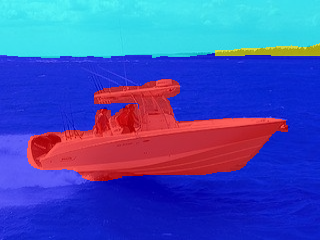

In [4]:
-- example blending
local k = 21
itorch.image(renderLabels(labels[k], images[k]))
-- itorch.image(comparePredictions(images[k], labels[k], predict(net, images[k])))

In [5]:
function jitterScale(img, labelsMat)
    local scaleDiffFactor = math.random() * 0.09 - 0.045 -- originally +/- 10%
    local heightDiff = math.floor(img:size(2) * scaleDiffFactor)
    local widthDiff = math.floor(img:size(3) * scaleDiffFactor)
    local padder = 
        nn.SpatialZeroPadding(widthDiff, widthDiff, heightDiff, heightDiff)

    local imgScaled = image.scale(padder:forward(img), 320, 240, 'bilinear')
    local labelsMatScaled = 
        image.scale(
            padder:forward(labelsMat:view(1, 240, 320)), 320, 240, 'simple')

    return imgScaled, labelsMatScaled:view(240, 320)
end

function jitter(img, labelsMat, flip)
    local imgFlipped, labelsMatFlipped

    if flip then
        imgFlipped = image.flip(img, 3)
        labelsMatFlipped = image.flip(labelsMat, 2)
    end

    local angle = (math.random() - 0.5) * (math.pi / 180 * 9)
    local imgRotated = image.rotate(imgFlipped or img, angle, 'bilinear')
    local labelsMatRotated = 
        image.rotate(labelsMatFlipped or labelsMat, angle, 'simple')

    return jitterScale(imgRotated, labelsMatRotated)
end

In [6]:
CUDA = true

In [7]:
Integral = nil
IntegralSmartNorm = nil
debug.getregistry()['Integral'] = nil 
debug.getregistry()['IntegralSmartNorm'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-c-multi'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil
package.loaded['Integral-cuda-multi'] = nil
package.loaded['IntegralSmartNorm'] = nil

require 'IntegralSmartNorm'

if CUDA then
    require 'cunn'
end

require 'nngraph'

In [8]:
-- testDir = 'SB overfit/window LR experiments, 2 layers, no constraints/x900/'

-- net = torch.load(testDir .. 'net.t7')
-- losses = torch.load(testDir .. 'loss-history.t7')
-- os.execute('mkdir "' .. testDir .. 'Images (test)" -p')

-- local ints = net:findModules('IntegralSmartNorm')
-- for i = 1,#ints do
--     ints[i].maxX = 1e6
--     ints[i].maxY = 1e6
-- end

In [9]:
-- graph version with conv1 to int2 connection
require 'nngraph'

collectgarbage()

inData = nn.Identity()()

int1 = IntegralSmartNorm(100, 240, 320)(inData) -- 3 -> 300
haar1 = nn.SpatialConvolutionMM(3*100, 15, 1,1,1,1)(int1) -- 300 -> 15
haar1rect = nn.LeakyReLU(0.03)(haar1)

conv1 = nn.SpatialConvolution(3, 14, 3,3, 1,1, 1,1)(inData) -- 3 -> 14
conv1rect = nn.LeakyReLU(0.03)(conv1)
conv1nin = nn.SpatialConvolutionMM(14, 5, 1,1,1,1)(conv1) -- 14 -> 5

join1 = nn.JoinTable(1,3)({haar1rect, conv1nin}) --15+5 = 20
int2 = IntegralSmartNorm(20, 240, 320)(join1) -- 20 -> 400

conv2 = nn.SpatialConvolution(14, 10, 3,3, 1,1, 1,1)(conv1rect) -- 8 -> 8
conv2rect = nn.LeakyReLU(0.03)(conv2)

join2 = nn.JoinTable(1,3)({int2, conv2rect}) -- 400+10 = 410

nin1 = nn.SpatialConvolutionMM(410, 32, 1,1,1,1)(join2) -- 410 -> 32
nin1rect = nn.LeakyReLU(0.03)(nin1)
nin2 = nn.SpatialConvolutionMM(32, 8, 1,1,1,1)(nin1rect) -- 32 -> 8

reshape = nn.Reshape(8, 240*320)(nin2)
transpose = nn.Transpose({2, 1})(reshape)

net = nn.gModule({inData}, {transpose})

local ints = net:findModules('IntegralSmartNorm')
for i = 1,#ints do
    ints[i].smart = true
    ints[i].exact = true
    ints[i].maxX = 100
    ints[i].maxY = 130
end

int1.data.module.gradInput = nil
conv1.data.module.gradInput = nil
conv1.data.module.updateGradInput = function(self) return torch.CudaTensor() end

if CUDA then
    require 'cunn'
    net:cuda()
end

In [8]:
outputDir = 'SB segmentation/12 graph 2 layers/'
os.execute('mkdir "' .. outputDir .. 'Images" -p')

In [11]:
net = torch.load(outputDir .. 'net.t7')
ints = net:findModules('IntegralSmartNorm')
for i = 1,#ints do
    ints[i].smart = true
    ints[i].exact = true
    ints[i].maxX = 130
    ints[i].maxY = 130
end

ints[1].gradInput = nil
-- net.modules[3].gradInput = nil
-- net.modules[3].updateGradInput = function(self) return torch.Tensor():typeAs(net.modules[3]) end

net:cuda()

losses = torch.load(outputDir .. 'loss-history.t7')

In [12]:
torch.manualSeed(666)
cutorch.manualSeed(666)

params, gradParams = net:parameters()

In [ ]:
losses = {}

In [13]:
local function calcClassWeights(labels)
    local counts = {}
    labels:apply(function(x) counts[x] = (counts[x] or 0) + 1 end)
    counts[0] = nil

    local sum = 0
    for k, v in pairs(counts) do
        sum = sum + v
    end

    for k, v in pairs(counts) do
        counts[k] = sum / v -- inverse frequency
    end

    local classWeights = torch.Tensor(counts)
    classWeights:div(classWeights:mean())
    return classWeights
end

criterion = nn.CrossEntropyCriterion(calcClassWeights(labels)):type(net.modules[1]:type())

In [14]:
require 'optim'

datasetIdx = 1

optimStates = {}

for i = 1,#params do
    local lr = 1e-3
    if i <= 4 or (i >= 11 and i <= 14) or (i >= 99 and i <= 99) then
        lr = lr * 500
    end
    
    optimStates[i] = {
        learningRate = lr,
        momentum = 0.73,
        nesterov = true,
        dampening = 0,
        learningRateDecay = 0.9993
    }
end

In [15]:
package.loaded.WindowDebugger = nil
debug.getregistry().WindowDebugger = nil
WindowDebugger = nil

require 'WindowDebugger'

windowDebugger_1 = WindowDebugger()
windowDebugger_2 = WindowDebugger()
windowDebugger_3 = WindowDebugger()

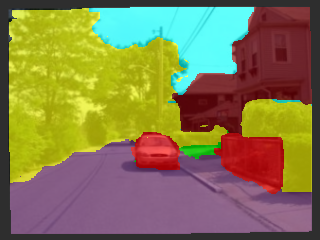

In [14]:
k = 13
img, lab = jitter(images[k], labels[k], true)
itorch.image(renderLabels(lab, img))

In [16]:
require 'gnuplot'

function plotLosses(losses)
    gnuplot.figure(1000)
    gnuplot.plot(torch.Tensor(losses), '-')
    gnuplot.axis{1, #losses, 0., 2.05}
    gnuplot.xlabel('Iteration')
    gnuplot.ylabel('Loss')
end

In [17]:
plotLosses(losses)

In [18]:
function predict(net, example)
    local pred = net:forward(example:type(net.modules[1]:type()))
    return select(2, pred:view(240, 320, 8):max(3)):squeeze():float()
end

function comparePredictions(img, labels, prediction, omitOriginal)
    img = img:clone():float()
    
    img:add(-img:min())
    img:div(img:max())
    
    local retval
    
    if omitOriginal then
        retval = torch.ones(3, img:size(2), img:size(3)*2 + 2)

        retval[{{}, {}, {1, img:size(3)}}]:copy(renderLabels(labels, img))
        retval[{{}, {}, {img:size(3)+3, img:size(3)*2+2}}]:copy(renderLabels(prediction, img))
    else
        retval = torch.ones(3, img:size(2), img:size(3)*3 + 4)
        retval[{{}, {}, {1, img:size(3)}}]:copy(img)
        retval[{{}, {}, {img:size(3)+3, img:size(3)*2+2}}]:copy(renderLabels(labels, img))
        retval[{{}, {}, {img:size(3)*2+5, retval:size(3)}}]:copy(renderLabels(prediction, img))
    end
    
    return retval
end

In [19]:
evaluationIdx = {
    26,13,58,74,89,98,103,110,132,127,630, -- buildings
    30,21,31,64,71,88,681, -- water/sand
    12,91,678,693, -- mountain
    3,59,82,118,120,698,650 -- grass/trees
}

table.sort(evaluationIdx)

In [20]:
function evaluate(net, images, labels, indices, outPath)
    local losses = {}
    local avgLoss = 0
    
    for k,idx in ipairs(indices) do
        local input = images[idx]:type(net.modules[1]:type())
        local outputs = net:forward(input)
        local target = labels[idx]:clone()
        
        if outPath then
            image.savePNG(
                outPath .. string.format('/%03d.png', idx), 
                comparePredictions(input, target, 
                    select(2, outputs:view(240, 320, 8):max(3)):squeeze():float()))
        end
        
        target = target:view(240*320)

        for i = 1,target:nElement() do
            if target[i] == 0 then
                target[i] = 3
                outputs[i]:zero()
                outputs[{i,3}] = 1e4
            end
        end

        target = target:type(criterion.lsm:type())

        local loss = criterion:forward(outputs, target)
        losses[k] = loss
        avgLoss = avgLoss + loss
    end
    
    collectgarbage()
    
    avgLoss = avgLoss / #indices
    
    return avgLoss, losses
end

## Training loop

In [ ]:
batchSize = 10
shuffleEvery = math.ceil(images:size(1) / batchSize) -- shuffle data every `shuffleEvery` iterations
outputFreq = 10 -- how often to output loss to `losses` table and to redraw loss graph
imgOutputFreq = 5 -- save validation predictions as images every `outputFreq*imgOutputFreq` iterations
saveFreq = 50 -- how often to save `net` and `windowDebugger`s

function randomShuffle(t)
  for i = 1,#t do
    local j = math.random(i, #t)
    t[i], t[j] = t[j], t[i]
  end
end

idx = {}
for i = 1,images:size(1) do
    idx[i] = i
end

local avgLoss = 0

for iter = 1,10000 do
    
    if (iter-1) % shuffleEvery == 0 then
        randomShuffle(idx)
        print('Epoch ' .. ((iter-1) / shuffleEvery))
    end
    
    windowDebugger_1:add(ints[1])
    windowDebugger_2:add(ints[2])
--     windowDebugger_3:add(net:get(7):get(1))
    
    local batchLoss = 0 -- at current minibatch
    
    -- forward + backward
    do
        net:zeroGradParameters()

        for k = 1,batchSize do

            local input, target = --jitter(
                images[idx[datasetIdx]], 
                labels[idx[datasetIdx]]
                --torch.random() % 2 == 0)
            
            if torch.random() % 2 == 0 then
                input = image.flip(input, 3)
                target = image.flip(target, 2)
            else
                target = target:clone()
            end
            
            target = target:view(240*320)
            
            input = input:type(net.modules[1]:type())
            local outputs = net:forward(input)

            for i = 1,target:nElement() do
                if target[i] == 0 then
                    target[i] = 3
                    outputs[i]:zero()
                    outputs[{i,3}] = 1e4
                end
            end
            
            target = target:type(net.modules[1]:type())

            batchLoss = batchLoss + criterion:forward(outputs, target)
            local dLoss_dOutputs = criterion:backward(outputs, target)
            net:backward(input, dLoss_dOutputs, 1/batchSize) -- accumulate gradients
            
            datasetIdx = datasetIdx % labels:size(1) + 1
        end
        
        batchLoss = batchLoss / batchSize
    end
    
    avgLoss = avgLoss + batchLoss
    
    -- optimization step
    for i = 1,#params do
        local feval = function(x)
            return batchLoss, gradParams[i]
        end

        optim.adam(feval, params[i], optimStates[i])
    end

    collectgarbage()

    if (iter-1) % outputFreq == 0 then
        losses[#losses+1] = 
            evaluate(net, images, labels, evaluationIdx,
            ((iter-1) % (outputFreq*imgOutputFreq) == 0) and (outputDir .. 'Images/'))
        -- losses[#losses+1] = avgLoss / outputFreq
        
        plotLosses(losses)
    end
    
    if (iter-1) % saveFreq == 0 then
        net:clearState()
        torch.save(outputDir .. 'net.t7', net)
        torch.save(outputDir .. 'loss-history.t7', losses)
        windowDebugger_1:exportVideo(outputDir .. 'int-layer-1.avi')
        windowDebugger_2:exportVideo(outputDir .. 'int-layer-2.avi')
--         windowDebugger_3:exportVideo(outputDir .. 'int-layer-3.avi')
    end
    
    if iter % 5 == 0 then
        print(
            'Iteration ' .. iter ..
            ', loss = ' .. (avgLoss / 5 or -1) .. ', ' .. os.date()
        )
        avgLoss = 0
    end
    
    if lfs.attributes(outputDir .. 'INTERRUPT') then
        os.rename(outputDir .. 'INTERRUPT', outputDir .. 'INTERRUPT_')
        break
    end
end

Epoch 0	


Iteration 5, loss = 0.74123320966959, Sat May  6 17:16:20 2017	


## Display predictions for test samples

In [19]:
local filenames = {}
for file in paths.files(relative .. 'images_test/') do
    if file:byte() ~= 46 then
        table.insert(filenames, file)
    end
end

table.sort(filenames)

local i = 1
while i <= #filenames do
    local img = image.scale(image.load(relative .. 'images_test/' .. filenames[i]), 320, 240, 'bicubic')
    
    local imgForNet = img:cuda()
    imgForNet:add(-mean)
    imgForNet:div(std)
    
    local prediction = predict(net, imgForNet)
    
    local output = torch.ones(3, img:size(2)*2 + 4, img:size(3))
    
    output[{{}, {1, img:size(2)}, {}}]:copy(img)
    output[{{}, {img:size(2)+3, img:size(2)*2+2}, {}}]:copy(renderLabels(prediction, img))
    
    image.save(testDir .. 'Images (test)/' .. '_' .. filenames[i], output)
    
    i = i + 1
end

collectgarbage()

In [349]:
evaluate(net, images, labels, evaluationIdx, outputDir .. 'Images/')

0.95531758357739	{
  1 : 0.64767742156982
  2 : 0.6600529551506
  3 : 0.69543921947479
  4 : 1.019557595253
  5 : 0.99425214529037
  6 : 0.80037921667099
  7 : 1.1323467493057
  8 : 0.9406573176384
  9 : 1.150452375412
  10 : 0.82327663898468
  11 : 0.5520516037941
  12 : 1.1003781557083
  13 : 1.0453722476959
  14 : 1.3467782735825
  15 : 1.0229215621948
  16 : 0.81896859407425
  17 : 0.7320744395256
  18 : 0.76737630367279
  19 : 1.5493805408478
  20 : 1.3646283149719
  21 : 0.89476817846298
  22 : 1.4090570211411
  23 : 1.0427916049957
  24 : 1.3882250785828
  25 : 1.2055470943451
  26 : 0.73753535747528
  27 : 0.91631376743317
  28 : 0.51084238290787
  29 : 0.43510776758194
}


## Overfit to small number of samples

In [33]:
outputDir = 'SB overfit/momentum, 2 layers, graph/666/'
os.execute('mkdir "' .. outputDir .. 'Images" -p')

In [34]:
torch.manualSeed(666)
cutorch.manualSeed(666)

net:reset()
params, gradParams = net:parameters()

losses = {}

In [35]:
require 'optim'

datasetIdx = 1

optimStates = {}

for i = 1,#params do
    local lr = 1e-3
    if i <= 4 or (i >= 11 and i <= 14) then
        lr = lr * 666 -- 2.5e3 -- lr * 400
    end
    
    optimStates[i] = {
        learningRate = lr,
        momentum = 0.9,
        nesterov = true,
        dampening = 0,
        learningRateDecay = 0.999
    }
end

In [36]:
package.loaded.WindowDebugger = nil
debug.getregistry().WindowDebugger = nil
WindowDebugger = nil

require 'WindowDebugger'

windowDebugger_1 = WindowDebugger()
windowDebugger_2 = WindowDebugger()
windowDebugger_3 = WindowDebugger()

In [37]:
idx = {55, 21, 26}
batchSize = #idx
shuffleEvery = 0 -- shuffle data every `shuffleEvery` iterations
outputFreq = 1 -- how often to output loss to `losses` table and to redraw loss graph
imgOutputFreq = 16 -- save validation predictions as images every `outputFreq*imgOutputFreq` iterations
saveFreq = 16 -- how often to save `net` and `windowDebugger`s

function randomShuffle(t)
  for i = 1,#t do
    local j = math.random(i, #t)
    t[i], t[j] = t[j], t[i]
  end
end

local avgLoss = 0

for iter = 1,999 do
    
    if (iter-1) % shuffleEvery == 0 then
        randomShuffle(idx)
        print('Epoch ' .. ((iter-1) / shuffleEvery))
    end
    
    windowDebugger_1:add(int1.data.module)
    windowDebugger_2:add(int2.data.module)
    
    local batchLoss = 0 -- at current minibatch
    local outputs
    
    -- forward + backward
    do
        net:zeroGradParameters()

        for k = 1,batchSize do

            local input, target = --jitter(
                images[idx[datasetIdx]], 
                labels[idx[datasetIdx]]--, 
                -- torch.random() % 2 == 0)
            
            target = target:view(240*320)

            input = input:type(int1.data.module:type())
            outputs = net:forward(input)
            
            if int1.data.module.outputOnes:lt(0.01):sum() > 0 then
                print('int1')
                batchLoss = 0/0
                break
            end
            
            if int2.data.module.outputOnes:lt(0.01):sum() > 0 then
                print('int2')
                batchLoss = 0/0
                break
            end
            
            if (iter-1) % (outputFreq * imgOutputFreq) == 0 then
                local outputImg = comparePredictions(images[idx[datasetIdx]], labels[idx[datasetIdx]], 
                            select(2, outputs:view(240, 320, 8):max(3)):squeeze():float())
                image.save(outputDir .. 'Images/' .. string.format('%03d.png', idx[datasetIdx]), outputImg)
            end

--             for i = 1,target:nElement() do
--                 if target[i] == 0 then
--                     target[i] = 3
--                     outputs[i]:zero()
--                     outputs[{i,3}] = 1e4
--                 end
--             end
            
            target = target:type(int1.data.module:type())

            batchLoss = batchLoss + criterion:forward(outputs, target)
            
            if batchLoss ~= batchLoss then
                print('1st')
                break
            end
            
            local dLoss_dOutputs = criterion:backward(outputs, target)
            net:backward(input, dLoss_dOutputs, 1/batchSize) -- accumulate gradients
            
            if int1.data.module.gradXMax[1] ~= int1.data.module.gradXMax[1] then
                print('2nd')
                batchLoss = 0/0
                break
            end
            
            datasetIdx = datasetIdx % #idx + 1
        end
        
        batchLoss = batchLoss / batchSize
    end
    
    if batchLoss ~= batchLoss then
        break
    end
    
    avgLoss = avgLoss + batchLoss
    
    -- optimization step
    for i = 1,#params do
        local feval = function(x)
            return batchLoss, gradParams[i]
        end

        optim.adam(feval, params[i], optimStates[i])
    end

    collectgarbage()

    if (iter-1) % outputFreq == 0 then
        
        losses[#losses+1] = avgLoss / outputFreq
        avgLoss = 0
        
        plotLosses(losses)
    end
    
    if (iter-1) % saveFreq == 0 or #losses == 500 then
        net:clearState()
        torch.save(outputDir .. 'net.t7', net)
        torch.save(outputDir .. 'loss-history.t7', losses)
        windowDebugger_1:exportVideo(outputDir .. 'int-layer-1.avi')
        windowDebugger_2:exportVideo(outputDir .. 'int-layer-2.avi')
--         windowDebugger_3:exportVideo(outputDir .. 'int-layer-3.avi')
        
        if #losses == 500 then break end
    end
    
    if iter % 4 == 0 then
        print('Iteration ' .. iter .. ', ' .. os.date())
    end
    
    if lfs.attributes(outputDir .. 'INTERRUPT') then
        os.rename(outputDir .. 'INTERRUPT', outputDir .. 'INTERRUPT_')
        break
    end
end

Iteration 4, Thu May  4 19:57:19 2017	


Iteration 8, Thu May  4 19:58:06 2017	


Iteration 12, Thu May  4 19:58:53 2017	


Iteration 16, Thu May  4 19:59:36 2017	


Iteration 20, Thu May  4 20:00:21 2017	


Iteration 24, Thu May  4 20:01:02 2017	


Iteration 28, Thu May  4 20:01:44 2017	


Iteration 32, Thu May  4 20:02:25 2017	


Iteration 36, Thu May  4 20:03:09 2017	


Iteration 40, Thu May  4 20:03:49 2017	


Iteration 44, Thu May  4 20:04:31 2017	


Iteration 48, Thu May  4 20:05:13 2017	


Iteration 52, Thu May  4 20:05:56 2017	


Iteration 56, Thu May  4 20:06:37 2017	


Iteration 60, Thu May  4 20:07:19 2017	


Iteration 64, Thu May  4 20:08:03 2017	


Iteration 68, Thu May  4 20:08:47 2017	


Iteration 72, Thu May  4 20:09:28 2017	


Iteration 76, Thu May  4 20:10:09 2017	


Iteration 80, Thu May  4 20:10:51 2017	


Iteration 84, Thu May  4 20:11:35 2017	


Iteration 88, Thu May  4 20:12:19 2017	


Iteration 92, Thu May  4 20:13:00 2017	


Iteration 96, Thu May  4 20:13:39 2017	


Iteration 100, Thu May  4 20:14:24 2017	


Iteration 104, Thu May  4 20:15:05 2017	


Iteration 108, Thu May  4 20:15:47 2017	


Iteration 112, Thu May  4 20:16:27 2017	


Iteration 116, Thu May  4 20:17:12 2017	


Iteration 120, Thu May  4 20:17:52 2017	


Iteration 124, Thu May  4 20:18:34 2017	


Iteration 128, Thu May  4 20:19:17 2017	


Iteration 132, Thu May  4 20:20:01 2017	


Iteration 136, Thu May  4 20:20:43 2017	


Iteration 140, Thu May  4 20:21:24 2017	


Iteration 144, Thu May  4 20:22:06 2017	


Iteration 148, Thu May  4 20:22:51 2017	


Iteration 152, Thu May  4 20:23:32 2017	


Iteration 156, Thu May  4 20:24:13 2017	


Iteration 160, Thu May  4 20:24:55 2017	


Iteration 164, Thu May  4 20:25:38 2017	


Iteration 168, Thu May  4 20:26:16 2017	


Iteration 172, Thu May  4 20:26:58 2017	


Iteration 176, Thu May  4 20:27:41 2017	


Iteration 180, Thu May  4 20:28:27 2017	


Iteration 184, Thu May  4 20:29:08 2017	


Iteration 188, Thu May  4 20:29:48 2017	


Iteration 192, Thu May  4 20:30:30 2017	


Iteration 196, Thu May  4 20:31:15 2017	


Iteration 200, Thu May  4 20:31:57 2017	


Iteration 204, Thu May  4 20:32:37 2017	


Iteration 208, Thu May  4 20:33:18 2017	


Iteration 212, Thu May  4 20:34:02 2017	


Iteration 216, Thu May  4 20:34:44 2017	


Iteration 220, Thu May  4 20:35:24 2017	


Iteration 224, Thu May  4 20:36:05 2017	


Iteration 228, Thu May  4 20:36:51 2017	


Iteration 232, Thu May  4 20:37:31 2017	


Iteration 236, Thu May  4 20:38:14 2017	


Iteration 240, Thu May  4 20:38:55 2017	


Iteration 244, Thu May  4 20:39:40 2017	


Iteration 248, Thu May  4 20:40:23 2017	


Iteration 252, Thu May  4 20:41:04 2017	


Iteration 256, Thu May  4 20:41:47 2017	


Iteration 260, Thu May  4 20:42:33 2017	


Iteration 264, Thu May  4 20:43:14 2017	


Iteration 268, Thu May  4 20:43:56 2017	


Iteration 272, Thu May  4 20:44:37 2017	


Iteration 276, Thu May  4 20:45:20 2017	


Iteration 280, Thu May  4 20:46:03 2017	


Iteration 284, Thu May  4 20:46:45 2017	


Iteration 288, Thu May  4 20:47:27 2017	


Iteration 292, Thu May  4 20:48:13 2017	


Iteration 296, Thu May  4 20:48:53 2017	


Iteration 300, Thu May  4 20:49:37 2017	


Iteration 304, Thu May  4 20:50:17 2017	


Iteration 308, Thu May  4 20:51:01 2017	


Iteration 312, Thu May  4 20:51:41 2017	


Iteration 316, Thu May  4 20:52:22 2017	


Iteration 320, Thu May  4 20:53:04 2017	


Iteration 324, Thu May  4 20:53:51 2017	


Iteration 328, Thu May  4 20:54:32 2017	


Iteration 332, Thu May  4 20:55:13 2017	


Iteration 336, Thu May  4 20:55:54 2017	


Iteration 340, Thu May  4 20:56:38 2017	


Iteration 344, Thu May  4 20:57:20 2017	


Iteration 348, Thu May  4 20:57:59 2017	


Iteration 352, Thu May  4 20:58:41 2017	


Iteration 356, Thu May  4 20:59:29 2017	


Iteration 360, Thu May  4 21:00:11 2017	


Iteration 364, Thu May  4 21:00:53 2017	


Iteration 368, Thu May  4 21:01:32 2017	


Iteration 372, Thu May  4 21:02:19 2017	


Iteration 376, Thu May  4 21:03:00 2017	


Iteration 380, Thu May  4 21:03:43 2017	


Iteration 384, Thu May  4 21:04:21 2017	


Iteration 388, Thu May  4 21:05:08 2017	


Iteration 392, Thu May  4 21:05:51 2017	


Iteration 396, Thu May  4 21:06:32 2017	


Iteration 400, Thu May  4 21:07:13 2017	


Iteration 404, Thu May  4 21:08:00 2017	


Iteration 408, Thu May  4 21:08:41 2017	


Iteration 412, Thu May  4 21:09:23 2017	


Iteration 416, Thu May  4 21:10:04 2017	


Iteration 420, Thu May  4 21:10:48 2017	


Iteration 424, Thu May  4 21:11:30 2017	


Iteration 428, Thu May  4 21:12:10 2017	


Iteration 432, Thu May  4 21:12:54 2017	


Iteration 436, Thu May  4 21:13:41 2017	


Iteration 440, Thu May  4 21:14:22 2017	


Iteration 444, Thu May  4 21:15:03 2017	


Iteration 448, Thu May  4 21:15:45 2017	


Iteration 452, Thu May  4 21:16:31 2017	


Iteration 456, Thu May  4 21:17:10 2017	


Iteration 460, Thu May  4 21:17:53 2017	


Iteration 464, Thu May  4 21:18:35 2017	


Iteration 468, Thu May  4 21:19:23 2017	


Iteration 472, Thu May  4 21:20:05 2017	


Iteration 476, Thu May  4 21:20:45 2017	


Iteration 480, Thu May  4 21:21:26 2017	


Iteration 484, Thu May  4 21:22:15 2017	


Iteration 488, Thu May  4 21:22:59 2017	


Iteration 492, Thu May  4 21:23:38 2017	


Iteration 496, Thu May  4 21:24:19 2017	


In [61]:
local input, target = --jitter(
                images[idx[datasetIdx]], 
                labels[idx[datasetIdx]]--, 
                -- torch.random() % 2 == 0)
            
target = target:view(240*320):typeAs(net)

-- probs = nn.SoftMax():typeAs(net):forward(net.output)
for k = 1,target:size(1) do
    local logloss = criterion:forward(net.output[k], target[k])
    if logloss ~= logloss then
        print(k)
--         break
    end
end

22721	
22722	
22723	
22724	
22725	
22726	
22727	


22728	
22729	
22730	
22731	
22732	
22733	
22734	
22735	
22736	
22737	
22738	
22739	
22740	
22741	
22742	
22743	
22744	


22745	
22746	
22747	
22748	
22749	
22750	
22751	
22752	
22753	
22754	
22755	
22756	
22757	
22758	
22759	
22760	


22761	
22762	
22763	
22764	
22765	
22766	
22767	
22768	
22769	
22770	
22771	
22772	
22773	
22774	
22775	


22776	
22777	
22778	
22779	
22780	
22781	
22782	
22783	
22784	
22785	
22786	
22787	
22788	
22789	
22790	
22791	
22792	


22793	
22794	
22795	
22796	
22797	


23041	
23042	
23043	
23044	
23045	
23046	
23047	
23048	
23049	
23050	
23051	
23052	
23053	
23054	
23055	


23056	
23057	
23058	
23059	
23060	
23061	
23062	
23063	
23064	
23065	
23066	
23067	
23068	
23069	
23070	
23071	
23072	


23073	
23074	
23075	
23076	
23077	
23078	
23079	
23080	
23081	
23082	
23083	
23084	
23085	
23086	
23087	
23088	


23089	
23090	
23091	


23092	
23093	
23094	
23095	
23096	
23097	
23098	
23099	
23100	
23101	
23102	
23103	


23104	
23105	
23106	
23107	
23108	
23109	
23110	
23111	
23112	
23113	
23114	
23115	
23116	
23117	


23361	
23362	
23363	
23364	
23365	
23366	
23367	
23368	
23369	
23370	
23371	
23372	
23373	
23374	


23375	
23376	
23377	
23378	
23379	
23380	
23381	
23382	
23383	
23384	
23385	
23386	
23387	
23388	
23389	
23390	
23391	
23392	
23393	
23394	
23395	
23396	


23397	
23398	
23399	
23400	
23401	
23402	
23403	
23404	
23405	
23406	
23407	
23408	
23409	
23410	
23411	


23412	
23413	
23414	
23415	
23416	
23417	
23418	
23419	
23420	
23421	
23422	
23423	
23424	
23425	


23426	
23427	
23428	
23429	
23430	


23431	
23432	
23433	
23434	


23435	
23436	
23437	


23681	
23682	
23683	
23684	
23685	
23686	
23687	
23688	
23689	
23690	
23691	
23692	
23693	


23694	
23695	
23696	
23697	
23698	
23699	
23700	
23701	
23702	
23703	


23704	
23705	
23706	
23707	
23708	
23709	
23710	
23711	
23712	
23713	
23714	
23715	
23716	
23717	
23718	


23719	
23720	
23721	
23722	
23723	
23724	
23725	
23726	
23727	
23728	
23729	
23730	
23731	
23732	
23733	
23734	


23735	
23736	
23737	
23738	
23739	
23740	
23741	
23742	
23743	
23744	
23745	
23746	
23747	
23748	
23749	
23750	


23751	
23752	
23753	
23754	
23755	
23756	
23757	


24001	
24002	
24003	
24004	
24005	
24006	
24007	
24008	
24009	
24010	


24011	
24012	
24013	
24014	
24015	
24016	
24017	
24018	
24019	
24020	
24021	
24022	
24023	
24024	
24025	
24026	


24027	
24028	
24029	
24030	
24031	
24032	
24033	
24034	
24035	
24036	
24037	
24038	
24039	
24040	
24041	
24042	
24043	


24044	
24045	
24046	
24047	
24048	
24049	
24050	
24051	
24052	
24053	
24054	
24055	
24056	
24057	
24058	
24059	


24060	
24061	
24062	
24063	
24064	
24065	
24066	
24067	
24068	
24069	
24070	
24071	
24072	
24073	


24074	
24075	
24076	
24077	


24321	
24322	
24323	
24324	
24325	
24326	
24327	
24328	
24329	
24330	
24331	
24332	


24333	
24334	
24335	
24336	
24337	
24338	
24339	
24340	
24341	
24342	
24343	
24344	
24345	
24346	
24347	


24348	
24349	
24350	
24351	
24352	
24353	
24354	
24355	
24356	
24357	
24358	
24359	
24360	
24361	
24362	
24363	


24364	
24365	
24366	
24367	
24368	
24369	
24370	
24371	
24372	
24373	
24374	
24375	
24376	
24377	
24378	
24379	


24380	
24381	
24382	
24383	
24384	
24385	
24386	
24387	
24388	
24389	
24390	
24391	
24392	
24393	
24394	


24395	
24396	
24397	


24641	
24642	


24643	
24644	
24645	
24646	
24647	
24648	
24649	
24650	
24651	
24652	
24653	
24654	
24655	
24656	
24657	


24658	
24659	
24660	
24661	
24662	
24663	
24664	
24665	
24666	
24667	
24668	
24669	
24670	
24671	
24672	


24673	
24674	
24675	
24676	
24677	
24678	
24679	
24680	
24681	
24682	
24683	
24684	
24685	
24686	


24687	
24688	
24689	
24690	
24691	
24692	
24693	
24694	
24695	
24696	
24697	
24698	
24699	
24700	
24701	


24702	
24703	
24704	
24705	
24706	
24707	
24708	
24709	
24710	
24711	
24712	
24713	
24714	


24715	
24716	
24717	


24961	
24962	
24963	
24964	
24965	
24966	
24967	
24968	


24969	
24970	
24971	
24972	
24973	
24974	
24975	
24976	
24977	
24978	
24979	
24980	
24981	
24982	


24983	
24984	
24985	
24986	
24987	
24988	
24989	
24990	
24991	
24992	
24993	
24994	
24995	
24996	
24997	


24998	
24999	
25000	
25001	
25002	
25003	
25004	


25005	
25006	
25007	
25008	
25009	
25010	
25011	
25012	
25013	
25014	
25015	
25016	
25017	
25018	
25019	


25020	
25021	
25022	
25023	
25024	
25025	
25026	
25027	
25028	
25029	
25030	
25031	
25032	
25033	


25034	
25035	
25036	
25037	


25281	
25282	
25283	
25284	
25285	
25286	
25287	
25288	
25289	


25290	
25291	
25292	
25293	
25294	
25295	
25296	
25297	
25298	


25299	
25300	
25301	
25302	
25303	
25304	
25305	
25306	
25307	


25308	
25309	
25310	
25311	
25312	
25313	
25314	
25315	
25316	
25317	
25318	
25319	
25320	
25321	
25322	
25323	


25324	
25325	
25326	
25327	
25328	
25329	
25330	
25331	
25332	
25333	
25334	
25335	
25336	
25337	
25338	
25339	


25340	
25341	
25342	
25343	
25344	
25345	
25346	
25347	
25348	
25349	
25350	
25351	
25352	
25353	
25354	
25355	


25356	
25357	


25601	
25602	
25603	
25604	
25605	
25606	
25607	
25608	
25609	
25610	
25611	
25612	
25613	
25614	
25615	


25616	
25617	
25618	
25619	
25620	
25621	
25622	
25623	
25624	
25625	
25626	
25627	
25628	
25629	
25630	


25631	
25632	
25633	
25634	
25635	
25636	
25637	
25638	
25639	
25640	
25641	
25642	
25643	
25644	
25645	


25646	
25647	
25648	
25649	
25650	
25651	
25652	
25653	
25654	
25655	
25656	
25657	
25658	
25659	
25660	


25661	
25662	
25663	
25664	
25665	
25666	
25667	
25668	
25669	
25670	
25671	
25672	
25673	
25674	
25675	


25676	
25677	


25921	
25922	
25923	
25924	
25925	
25926	
25927	
25928	
25929	
25930	
25931	


25932	
25933	
25934	
25935	
25936	
25937	
25938	
25939	
25940	
25941	
25942	
25943	
25944	
25945	
25946	
25947	


25948	
25949	
25950	
25951	
25952	
25953	
25954	
25955	
25956	
25957	
25958	
25959	
25960	
25961	
25962	
25963	
25964	


25965	
25966	
25967	
25968	
25969	
25970	
25971	
25972	
25973	
25974	
25975	
25976	
25977	
25978	
25979	
25980	


25981	
25982	
25983	
25984	
25985	
25986	
25987	
25988	
25989	
25990	
25991	
25992	
25993	
25994	
25995	
25996	


25997	


26241	
26242	


26243	


26244	
26245	
26246	
26247	
26248	
26249	
26250	
26251	
26252	
26253	
26254	


26255	
26256	
26257	
26258	
26259	
26260	
26261	
26262	
26263	
26264	
26265	
26266	
26267	
26268	


26269	
26270	
26271	
26272	
26273	
26274	
26275	
26276	
26277	
26278	
26279	
26280	
26281	
26282	
26283	


26284	
26285	
26286	
26287	
26288	
26289	
26290	
26291	
26292	
26293	
26294	
26295	
26296	
26297	


26298	
26299	
26300	
26301	
26302	
26303	
26304	
26305	
26306	
26307	
26308	
26309	
26310	
26311	
26312	


26313	
26314	
26315	
26316	
26317	


26561	
26562	
26563	
26564	
26565	
26566	
26567	
26568	
26569	
26570	
26571	
26572	
26573	


26574	
26575	
26576	
26577	
26578	
26579	
26580	
26581	
26582	
26583	
26584	
26585	
26586	
26587	


26588	
26589	
26590	
26591	
26592	
26593	
26594	
26595	
26596	
26597	
26598	
26599	
26600	
26601	


26602	
26603	
26604	
26605	
26606	
26607	
26608	
26609	
26610	
26611	
26612	
26613	
26614	


26615	
26616	
26617	
26618	
26619	
26620	
26621	
26622	
26623	
26624	
26625	
26626	
26627	


26628	
26629	
26630	
26631	
26632	
26633	
26634	
26635	
26636	
26637	


26881	
26882	
26883	
26884	
26885	
26886	
26887	
26888	
26889	
26890	
26891	
26892	
26893	


26894	
26895	
26896	
26897	
26898	
26899	
26900	
26901	
26902	
26903	
26904	
26905	
26906	
26907	
26908	


26909	
26910	
26911	
26912	
26913	
26914	
26915	
26916	
26917	
26918	
26919	
26920	
26921	
26922	


26923	
26924	
26925	
26926	
26927	
26928	
26929	
26930	
26931	
26932	
26933	
26934	
26935	
26936	


26937	
26938	
26939	
26940	
26941	
26942	
26943	
26944	
26945	
26946	
26947	
26948	
26949	
26950	


26951	
26952	
26953	
26954	
26955	
26956	
26957	


27201	
27202	
27203	
27204	
27205	
27206	
27207	
27208	
27209	


27210	
27211	
27212	
27213	
27214	
27215	
27216	
27217	
27218	
27219	
27220	
27221	
27222	
27223	


27224	
27225	
27226	
27227	
27228	
27229	
27230	
27231	
27232	
27233	
27234	
27235	
27236	
27237	


27238	
27239	
27240	
27241	
27242	
27243	
27244	
27245	
27246	
27247	
27248	


27249	
27250	
27251	
27252	
27253	
27254	
27255	
27256	
27257	
27258	


27259	
27260	
27261	
27262	
27263	
27264	
27265	
27266	


27267	
27268	
27269	
27270	
27271	
27272	
27273	
27274	
27275	
27276	


27277	


27521	


27522	
27523	
27524	
27525	
27526	
27527	
27528	
27529	
27530	


27531	
27532	
27533	
27534	
27535	
27536	
27537	
27538	
27539	
27540	
27541	


27542	
27543	
27544	
27545	
27546	
27547	
27548	
27549	
27550	
27551	
27552	
27553	
27554	


27555	
27556	
27557	
27558	
27559	
27560	
27561	
27562	
27563	
27564	
27565	
27566	


27567	
27568	
27569	
27570	
27571	
27572	
27573	
27574	
27575	
27576	
27577	
27578	


27579	
27580	
27581	
27582	
27583	
27584	
27585	
27586	
27587	
27588	
27589	
27590	


27591	
27592	
27593	
27594	
27595	
27596	
27597	


27841	
27842	
27843	
27844	
27845	
27846	
27847	
27848	
27849	
27850	


27851	
27852	
27853	
27854	
27855	
27856	
27857	
27858	
27859	


27860	
27861	
27862	
27863	
27864	
27865	
27866	
27867	
27868	
27869	


27870	
27871	
27872	
27873	
27874	
27875	
27876	
27877	
27878	
27879	


27880	
27881	
27882	
27883	
27884	
27885	
27886	
27887	
27888	
27889	
27890	


27891	
27892	
27893	
27894	
27895	
27896	
27897	
27898	
27899	
27900	


27901	
27902	
27903	
27904	
27905	
27906	
27907	
27908	
27909	
27910	
27911	


27912	
27913	
27914	
27915	
27916	
27917	


28161	
28162	
28163	
28164	
28165	


28166	
28167	
28168	
28169	
28170	
28171	
28172	
28173	
28174	
28175	
28176	


28177	
28178	
28179	
28180	
28181	
28182	
28183	
28184	
28185	
28186	
28187	


28188	
28189	
28190	
28191	
28192	
28193	
28194	
28195	
28196	
28197	


28198	
28199	
28200	
28201	
28202	
28203	
28204	
28205	
28206	
28207	
28208	


28209	
28210	
28211	
28212	
28213	
28214	
28215	
28216	
28217	
28218	
28219	


28220	
28221	
28222	
28223	
28224	
28225	
28226	
28227	
28228	
28229	
28230	


28231	
28232	
28233	
28234	
28235	
28236	
28237	


28481	
28482	
28483	
28484	
28485	
28486	
28487	


28488	
28489	
28490	
28491	
28492	
28493	
28494	
28495	
28496	
28497	
28498	
28499	
28500	


28501	
28502	
28503	
28504	
28505	
28506	
28507	
28508	
28509	
28510	
28511	
28512	
28513	
28514	


28515	
28516	
28517	
28518	
28519	
28520	
28521	
28522	
28523	
28524	
28525	
28526	
28527	


28528	
28529	
28530	
28531	
28532	
28533	
28534	
28535	
28536	
28537	
28538	
28539	
28540	
28541	


28542	
28543	
28544	
28545	
28546	
28547	
28548	
28549	
28550	
28551	
28552	


28553	
28554	
28555	
28556	
28557	


28801	
28802	
28803	
28804	
28805	
28806	
28807	


28808	
28809	
28810	
28811	
28812	
28813	
28814	
28815	
28816	
28817	
28818	


28819	
28820	
28821	
28822	
28823	
28824	
28825	
28826	
28827	
28828	


28829	
28830	
28831	
28832	
28833	
28834	
28835	
28836	
28837	
28838	
28839	


28840	
28841	
28842	
28843	
28844	
28845	
28846	
28847	
28848	
28849	


28850	
28851	
28852	
28853	
28854	
28855	
28856	
28857	
28858	
28859	
28860	


28861	
28862	
28863	
28864	
28865	
28866	
28867	
28868	
28869	
28870	
28871	


28872	
28873	
28874	
28875	
28876	
28877	


29121	
29122	
29123	
29124	
29125	
29126	


29127	
29128	
29129	
29130	
29131	
29132	
29133	
29134	
29135	
29136	
29137	


29138	
29139	
29140	
29141	
29142	
29143	
29144	
29145	
29146	
29147	
29148	


29149	
29150	
29151	
29152	
29153	
29154	
29155	
29156	
29157	
29158	


29159	
29160	
29161	
29162	
29163	
29164	
29165	
29166	
29167	
29168	
29169	


29170	
29171	
29172	
29173	
29174	
29175	
29176	
29177	
29178	
29179	
29180	


29181	
29182	
29183	
29184	
29185	
29186	
29187	
29188	
29189	


29190	
29191	
29192	
29193	
29194	
29195	
29196	
29197	


29441	
29442	
29443	
29444	
29445	
29446	
29447	
29448	
29449	
29450	


29451	
29452	
29453	
29454	
29455	
29456	
29457	
29458	
29459	
29460	


29461	
29462	
29463	
29464	
29465	
29466	
29467	
29468	
29469	
29470	
29471	
29472	
29473	
29474	


29475	
29476	
29477	
29478	
29479	
29480	
29481	
29482	
29483	
29484	
29485	
29486	
29487	


29488	
29489	
29490	
29491	
29492	
29493	
29494	
29495	
29496	
29497	
29498	
29499	
29500	
29501	


29502	
29503	
29504	
29505	
29506	
29507	
29508	
29509	
29510	
29511	
29512	
29513	
29514	


29515	
29516	
29517	


29761	
29762	
29763	
29764	
29765	
29766	


29767	
29768	
29769	
29770	
29771	
29772	
29773	
29774	
29775	
29776	
29777	
29778	
29779	
29780	


29781	
29782	
29783	
29784	
29785	
29786	
29787	
29788	
29789	
29790	
29791	
29792	
29793	
29794	


29795	
29796	
29797	
29798	
29799	
29800	
29801	
29802	
29803	
29804	
29805	
29806	
29807	
29808	


29809	
29810	
29811	
29812	
29813	
29814	
29815	
29816	
29817	
29818	
29819	
29820	
29821	


29822	
29823	
29824	
29825	
29826	
29827	
29828	
29829	
29830	
29831	
29832	
29833	
29834	
29835	


29836	
29837	


30081	
30082	
30083	


30084	
30085	
30086	
30087	
30088	
30089	
30090	
30091	
30092	
30093	
30094	
30095	
30096	
30097	


30098	
30099	
30100	
30101	
30102	
30103	
30104	
30105	
30106	
30107	
30108	
30109	
30110	
30111	


30112	
30113	
30114	
30115	
30116	
30117	
30118	
30119	
30120	
30121	
30122	
30123	
30124	
30125	


30126	
30127	
30128	
30129	
30130	
30131	
30132	
30133	
30134	
30135	
30136	
30137	
30138	


30139	
30140	
30141	
30142	
30143	
30144	
30145	
30146	
30147	
30148	
30149	
30150	
30151	
30152	
30153	


30154	
30155	
30156	
30157	


30401	
30402	
30403	


30404	
30405	
30406	
30407	
30408	
30409	
30410	
30411	
30412	
30413	
30414	


30415	
30416	
30417	
30418	
30419	
30420	
30421	
30422	
30423	
30424	
30425	
30426	
30427	
30428	


30429	
30430	
30431	
30432	
30433	
30434	
30435	
30436	
30437	
30438	
30439	


30440	
30441	
30442	
30443	
30444	
30445	
30446	
30447	
30448	
30449	
30450	


30451	
30452	
30453	
30454	
30455	
30456	
30457	
30458	


30459	
30460	
30461	
30462	
30463	
30464	
30465	
30466	
30467	


30468	
30469	


30470	
30471	
30472	
30473	


30474	
30475	
30476	
30477	


30721	
30722	
30723	
30724	
30725	
30726	
30727	
30728	
30729	


30730	
30731	
30732	
30733	
30734	
30735	
30736	
30737	
30738	
30739	
30740	
30741	
30742	
30743	
30744	
30745	


30746	
30747	
30748	
30749	
30750	
30751	
30752	
30753	
30754	
30755	
30756	
30757	
30758	


30759	
30760	
30761	
30762	
30763	
30764	
30765	
30766	
30767	
30768	
30769	
30770	
30771	
30772	
30773	


30774	
30775	
30776	
30777	
30778	
30779	
30780	
30781	
30782	
30783	
30784	
30785	
30786	
30787	
30788	
30789	
30790	


30791	
30792	
30793	
30794	
30795	
30796	
30797	


31041	


31042	
31043	
31044	
31045	
31046	
31047	
31048	
31049	
31050	
31051	
31052	
31053	
31054	
31055	
31056	
31057	
31058	
31059	


31060	
31061	
31062	
31063	
31064	
31065	
31066	
31067	
31068	
31069	
31070	
31071	
31072	
31073	
31074	
31075	
31076	


31077	
31078	
31079	
31080	
31081	
31082	
31083	
31084	
31085	
31086	
31087	
31088	
31089	
31090	
31091	
31092	
31093	


31094	
31095	
31096	
31097	
31098	
31099	
31100	
31101	
31102	
31103	
31104	
31105	
31106	
31107	
31108	
31109	
31110	


31111	
31112	
31113	
31114	
31115	
31116	
31117	


31361	
31362	
31363	
31364	


31365	
31366	
31367	
31368	
31369	
31370	
31371	
31372	
31373	
31374	
31375	
31376	
31377	
31378	
31379	
31380	
31381	
31382	


31383	
31384	
31385	
31386	
31387	
31388	
31389	
31390	
31391	
31392	
31393	
31394	
31395	
31396	
31397	
31398	
31399	
31400	


31401	
31402	
31403	
31404	
31405	
31406	
31407	
31408	
31409	
31410	
31411	
31412	
31413	
31414	
31415	
31416	
31417	


31418	
31419	
31420	
31421	
31422	
31423	
31424	
31425	
31426	
31427	
31428	
31429	
31430	
31431	
31432	
31433	
31434	


31435	
31436	
31437	


31681	
31682	
31683	
31684	
31685	
31686	
31687	


31688	
31689	
31690	
31691	
31692	
31693	
31694	
31695	
31696	
31697	
31698	
31699	
31700	
31701	
31702	
31703	


31704	
31705	
31706	
31707	
31708	
31709	
31710	
31711	
31712	
31713	
31714	
31715	
31716	
31717	
31718	
31719	


31720	
31721	
31722	
31723	
31724	
31725	
31726	
31727	
31728	
31729	
31730	
31731	
31732	
31733	
31734	
31735	


31736	
31737	
31738	
31739	
31740	
31741	
31742	
31743	
31744	
31745	
31746	
31747	
31748	
31749	
31750	
31751	


31752	
31753	
31754	
31755	
31756	
31757	


32001	
32002	
32003	
32004	
32005	


32006	
32007	
32008	
32009	
32010	
32011	
32012	
32013	
32014	
32015	
32016	
32017	
32018	
32019	
32020	
32021	
32022	
32023	


32024	
32025	
32026	
32027	
32028	
32029	
32030	
32031	
32032	
32033	
32034	
32035	
32036	
32037	
32038	
32039	
32040	


32041	
32042	
32043	
32044	
32045	
32046	
32047	
32048	
32049	
32050	
32051	
32052	
32053	
32054	
32055	


32056	
32057	
32058	
32059	
32060	
32061	
32062	
32063	
32064	
32065	
32066	
32067	
32068	
32069	
32070	
32071	
32072	
32073	


32074	
32075	
32076	
32077	


32321	
32322	
32323	
32324	
32325	


32326	
32327	
32328	
32329	
32330	
32331	
32332	
32333	
32334	
32335	
32336	
32337	
32338	
32339	
32340	
32341	
32342	


32343	
32344	
32345	
32346	
32347	
32348	
32349	
32350	
32351	
32352	
32353	
32354	
32355	
32356	
32357	
32358	
32359	


32360	
32361	
32362	
32363	
32364	
32365	
32366	
32367	
32368	
32369	
32370	
32371	
32372	
32373	
32374	
32375	
32376	


32377	
32378	
32379	
32380	
32381	
32382	
32383	
32384	
32385	
32386	
32387	
32388	
32389	
32390	
32391	
32392	
32393	


32394	
32395	
32396	
32397	


32641	
32642	
32643	
32644	
32645	


32646	
32647	
32648	
32649	
32650	
32651	
32652	
32653	
32654	
32655	
32656	
32657	
32658	
32659	
32660	
32661	
32662	


32663	
32664	
32665	
32666	
32667	
32668	
32669	
32670	
32671	
32672	
32673	
32674	


32675	
32676	
32677	
32678	
32679	
32680	
32681	
32682	
32683	
32684	
32685	
32686	
32687	
32688	
32689	


32690	
32691	
32692	
32693	
32694	
32695	
32696	
32697	
32698	
32699	
32700	
32701	


32702	
32703	
32704	
32705	
32706	
32707	
32708	
32709	
32710	
32711	
32712	


32713	
32714	
32715	
32716	
32717	


32961	
32962	
32963	
32964	
32965	
32966	
32967	


32968	
32969	
32970	
32971	
32972	
32973	
32974	
32975	
32976	
32977	
32978	
32979	
32980	
32981	
32982	
32983	
32984	
32985	


32986	
32987	
32988	
32989	
32990	
32991	
32992	
32993	
32994	
32995	
32996	
32997	
32998	
32999	
33000	
33001	
33002	


33003	
33004	
33005	
33006	
33007	
33008	
33009	
33010	
33011	
33012	
33013	
33014	
33015	
33016	
33017	
33018	
33019	


33020	
33021	
33022	
33023	
33024	
33025	
33026	
33027	
33028	
33029	
33030	
33031	
33032	
33033	
33034	
33035	
33036	


33037	


33281	
33282	
33283	
33284	
33285	
33286	
33287	
33288	
33289	
33290	
33291	
33292	


33293	
33294	
33295	
33296	
33297	
33298	
33299	
33300	
33301	
33302	
33303	
33304	
33305	
33306	
33307	
33308	
33309	
33310	


33311	
33312	
33313	
33314	
33315	
33316	
33317	
33318	
33319	
33320	
33321	
33322	
33323	
33324	
33325	
33326	
33327	


33328	
33329	
33330	
33331	
33332	
33333	
33334	
33335	
33336	
33337	
33338	
33339	
33340	
33341	
33342	
33343	
33344	


33345	
33346	
33347	
33348	
33349	
33350	
33351	
33352	
33353	
33354	
33355	
33356	
33357	


33601	
33602	
33603	
33604	
33605	
33606	
33607	
33608	
33609	
33610	
33611	
33612	
33613	
33614	


33615	
33616	
33617	
33618	
33619	
33620	
33621	
33622	
33623	
33624	
33625	
33626	
33627	
33628	
33629	
33630	
33631	


33632	
33633	
33634	
33635	
33636	
33637	
33638	
33639	
33640	
33641	
33642	
33643	
33644	
33645	
33646	
33647	
33648	


33649	
33650	
33651	
33652	
33653	
33654	
33655	
33656	
33657	
33658	
33659	
33660	
33661	
33662	
33663	
33664	
33665	
33666	


33667	
33668	
33669	
33670	
33671	
33672	
33673	
33674	
33675	
33676	
33677	


33921	
33922	
33923	
33924	
33925	
33926	
33927	
33928	


33929	
33930	
33931	
33932	
33933	
33934	
33935	
33936	
33937	
33938	
33939	
33940	
33941	
33942	


33943	
33944	
33945	
33946	
33947	
33948	
33949	
33950	
33951	
33952	
33953	
33954	
33955	
33956	
33957	
33958	


33959	
33960	
33961	
33962	
33963	
33964	
33965	
33966	
33967	
33968	
33969	
33970	
33971	
33972	
33973	


33974	
33975	
33976	
33977	
33978	
33979	
33980	
33981	
33982	
33983	
33984	
33985	
33986	
33987	
33988	
33989	


33990	
33991	
33992	
33993	
33994	
33995	
33996	
33997	


34241	
34242	
34243	
34244	
34245	
34246	
34247	
34248	
34249	
34250	
34251	
34252	


34253	
34254	
34255	
34256	
34257	
34258	
34259	
34260	
34261	
34262	
34263	
34264	
34265	
34266	
34267	
34268	
34269	


34270	
34271	
34272	
34273	
34274	
34275	
34276	
34277	
34278	
34279	
34280	
34281	
34282	
34283	
34284	
34285	
34286	


34287	
34288	
34289	
34290	
34291	
34292	
34293	
34294	
34295	
34296	
34297	
34298	
34299	
34300	
34301	
34302	


34303	
34304	
34305	
34306	
34307	
34308	
34309	
34310	
34311	
34312	
34313	
34314	
34315	
34316	
34317	


34561	
34562	
34563	
34564	
34565	
34566	
34567	
34568	
34569	
34570	


34571	
34572	
34573	
34574	
34575	
34576	
34577	
34578	
34579	
34580	
34581	
34582	
34583	
34584	
34585	
34586	
34587	


34588	
34589	
34590	
34591	
34592	
34593	
34594	
34595	
34596	
34597	
34598	
34599	
34600	
34601	
34602	
34603	
34604	


34605	
34606	
34607	


34608	
34609	
34610	
34611	
34612	
34613	
34614	
34615	


34616	
34617	
34618	
34619	
34620	
34621	
34622	
34623	
34624	
34625	
34626	
34627	
34628	
34629	
34630	
34631	
34632	


34633	
34634	
34635	
34636	
34637	


34881	
34882	
34883	
34884	
34885	
34886	
34887	


34888	
34889	
34890	
34891	
34892	
34893	
34894	
34895	
34896	
34897	
34898	
34899	


34900	
34901	
34902	
34903	
34904	
34905	
34906	
34907	
34908	
34909	
34910	
34911	
34912	


34913	
34914	
34915	
34916	
34917	
34918	
34919	
34920	
34921	
34922	
34923	
34924	
34925	


34926	
34927	
34928	
34929	
34930	
34931	
34932	
34933	
34934	
34935	
34936	
34937	
34938	
34939	
34940	
34941	


34942	
34943	
34944	
34945	
34946	
34947	
34948	
34949	
34950	
34951	
34952	


34953	
34954	
34955	
34956	
34957	


35201	
35202	
35203	
35204	
35205	
35206	
35207	


35208	
35209	
35210	
35211	
35212	
35213	
35214	
35215	
35216	
35217	
35218	
35219	
35220	
35221	
35222	
35223	


35224	
35225	
35226	
35227	
35228	
35229	
35230	
35231	
35232	
35233	
35234	
35235	
35236	
35237	
35238	
35239	


35240	
35241	
35242	
35243	
35244	
35245	
35246	
35247	
35248	
35249	
35250	
35251	
35252	
35253	
35254	
35255	
35256	


35257	
35258	
35259	
35260	
35261	
35262	
35263	
35264	
35265	
35266	
35267	
35268	
35269	
35270	
35271	
35272	


35273	
35274	
35275	
35276	
35277	


35521	
35522	
35523	
35524	
35525	


35526	
35527	
35528	
35529	
35530	
35531	
35532	
35533	
35534	
35535	
35536	
35537	
35538	
35539	
35540	
35541	


35542	
35543	
35544	
35545	
35546	
35547	
35548	
35549	
35550	
35551	
35552	
35553	
35554	
35555	
35556	
35557	
35558	


35559	
35560	
35561	
35562	
35563	
35564	
35565	
35566	
35567	
35568	
35569	
35570	
35571	
35572	
35573	
35574	


35575	
35576	
35577	
35578	
35579	
35580	
35581	
35582	
35583	
35584	
35585	
35586	
35587	
35588	
35589	
35590	


35591	
35592	
35593	
35594	
35595	
35596	
35597	


35841	


35842	
35843	
35844	
35845	
35846	
35847	
35848	
35849	
35850	
35851	
35852	
35853	
35854	
35855	
35856	
35857	


35858	
35859	
35860	
35861	
35862	
35863	
35864	
35865	
35866	
35867	
35868	
35869	
35870	
35871	
35872	
35873	
35874	


35875	
35876	
35877	
35878	
35879	
35880	
35881	
35882	
35883	
35884	
35885	
35886	
35887	
35888	
35889	
35890	


35891	
35892	
35893	
35894	
35895	
35896	
35897	
35898	
35899	
35900	
35901	
35902	
35903	
35904	
35905	
35906	


35907	
35908	
35909	
35910	
35911	
35912	
35913	
35914	
35915	
35916	
35917	


36161	
36162	
36163	
36164	
36165	
36166	
36167	
36168	
36169	
36170	
36171	
36172	
36173	
36174	


36175	
36176	
36177	
36178	
36179	
36180	
36181	
36182	
36183	
36184	
36185	
36186	
36187	
36188	
36189	
36190	


36191	
36192	
36193	
36194	
36195	
36196	
36197	
36198	
36199	
36200	
36201	
36202	
36203	
36204	
36205	
36206	


36207	
36208	
36209	
36210	
36211	
36212	
36213	
36214	
36215	
36216	
36217	
36218	
36219	
36220	
36221	


36222	
36223	
36224	
36225	
36226	
36227	
36228	
36229	
36230	
36231	
36232	
36233	
36234	
36235	
36236	
36237	


36481	
36482	
36483	
36484	
36485	
36486	


36487	
36488	
36489	
36490	
36491	
36492	
36493	
36494	
36495	
36496	
36497	
36498	
36499	
36500	
36501	
36502	
36503	


36504	
36505	
36506	
36507	
36508	
36509	
36510	
36511	
36512	
36513	
36514	
36515	
36516	
36517	
36518	
36519	


36520	
36521	
36522	
36523	
36524	
36525	
36526	
36527	
36528	
36529	
36530	
36531	
36532	
36533	
36534	
36535	


36536	
36537	
36538	
36539	
36540	
36541	
36542	
36543	
36544	
36545	
36546	
36547	
36548	
36549	
36550	
36551	


36552	


36553	
36554	
36555	
36556	
36557	


36801	
36802	
36803	
36804	
36805	


36806	
36807	
36808	
36809	
36810	
36811	
36812	
36813	
36814	
36815	
36816	
36817	
36818	
36819	
36820	
36821	


36822	
36823	
36824	
36825	
36826	
36827	
36828	
36829	
36830	
36831	
36832	
36833	
36834	
36835	
36836	
36837	


36838	
36839	
36840	
36841	
36842	
36843	
36844	
36845	
36846	
36847	
36848	
36849	
36850	
36851	
36852	
36853	
36854	


36855	
36856	
36857	
36858	
36859	
36860	
36861	
36862	


36863	
36864	
36865	
36866	
36867	
36868	
36869	
36870	
36871	
36872	
36873	
36874	
36875	
36876	
36877	


37121	
37122	
37123	
37124	
37125	
37126	
37127	
37128	
37129	
37130	
37131	
37132	


37133	
37134	
37135	
37136	
37137	
37138	
37139	
37140	
37141	
37142	
37143	
37144	
37145	
37146	


37147	
37148	
37149	
37150	
37151	
37152	
37153	
37154	
37155	
37156	
37157	
37158	
37159	


37160	
37161	
37162	
37163	
37164	
37165	
37166	
37167	
37168	
37169	
37170	
37171	


37172	
37173	
37174	
37175	
37176	
37177	
37178	
37179	
37180	
37181	
37182	
37183	
37184	


37185	
37186	
37187	
37188	
37189	
37190	
37191	
37192	
37193	
37194	
37195	
37196	
37197	


37441	
37442	
37443	
37444	
37445	
37446	
37447	
37448	
37449	
37450	


37451	
37452	
37453	
37454	
37455	
37456	
37457	
37458	
37459	
37460	
37461	
37462	
37463	


37464	
37465	
37466	
37467	
37468	
37469	
37470	
37471	
37472	
37473	
37474	
37475	
37476	


37477	
37478	
37479	
37480	
37481	
37482	
37483	
37484	
37485	
37486	
37487	
37488	
37489	


37490	
37491	
37492	
37493	
37494	
37495	
37496	
37497	
37498	
37499	
37500	
37501	
37502	


37503	
37504	
37505	
37506	
37507	
37508	
37509	
37510	
37511	
37512	
37513	
37514	


37515	
37516	
37517	


37761	
37762	
37763	
37764	
37765	
37766	
37767	


37768	
37769	
37770	
37771	
37772	
37773	
37774	
37775	
37776	
37777	
37778	
37779	


37780	
37781	
37782	
37783	
37784	
37785	
37786	
37787	
37788	
37789	
37790	
37791	
37792	
37793	


37794	
37795	
37796	
37797	
37798	
37799	
37800	
37801	
37802	
37803	
37804	
37805	
37806	


37807	
37808	
37809	
37810	
37811	
37812	
37813	
37814	
37815	
37816	
37817	
37818	
37819	
37820	
37821	


37822	
37823	
37824	
37825	
37826	
37827	
37828	
37829	
37830	
37831	
37832	
37833	
37834	
37835	


37836	
37837	


38081	
38082	
38083	
38084	
38085	
38086	
38087	


38088	
38089	
38090	
38091	
38092	
38093	
38094	
38095	
38096	
38097	
38098	
38099	
38100	
38101	
38102	
38103	


38104	
38105	
38106	
38107	
38108	
38109	
38110	
38111	
38112	
38113	
38114	
38115	
38116	
38117	


38118	
38119	
38120	
38121	
38122	
38123	
38124	
38125	
38126	
38127	
38128	
38129	
38130	
38131	


38132	
38133	
38134	
38135	
38136	
38137	
38138	
38139	
38140	
38141	
38142	
38143	
38144	
38145	


38146	
38147	
38148	
38149	
38150	
38151	
38152	
38153	
38154	
38155	
38156	
38157	


38401	
38402	
38403	
38404	
38405	


38406	
38407	
38408	
38409	
38410	
38411	
38412	
38413	
38414	
38415	
38416	
38417	
38418	
38419	


38420	
38421	
38422	
38423	
38424	
38425	
38426	
38427	
38428	
38429	
38430	
38431	
38432	
38433	


38434	
38435	
38436	
38437	
38438	
38439	
38440	
38441	
38442	
38443	
38444	
38445	
38446	
38447	


38448	
38449	
38450	
38451	
38452	
38453	
38454	
38455	
38456	
38457	
38458	
38459	
38460	


38461	
38462	
38463	
38464	
38465	
38466	
38467	
38468	
38469	
38470	
38471	
38472	
38473	


38474	
38475	
38476	
38477	


38721	
38722	
38723	


38724	
38725	
38726	
38727	
38728	
38729	
38730	
38731	
38732	
38733	
38734	
38735	
38736	
38737	


38738	
38739	
38740	
38741	
38742	
38743	
38744	
38745	
38746	
38747	
38748	
38749	
38750	


38751	
38752	
38753	
38754	
38755	
38756	
38757	
38758	
38759	
38760	
38761	
38762	
38763	


38764	
38765	
38766	
38767	
38768	
38769	
38770	
38771	
38772	
38773	
38774	
38775	
38776	


38777	
38778	
38779	
38780	
38781	
38782	
38783	
38784	
38785	
38786	
38787	
38788	
38789	
38790	


38791	
38792	
38793	
38794	
38795	
38796	
38797	


39041	
39042	
39043	
39044	
39045	
39046	
39047	


39048	
39049	
39050	
39051	
39052	
39053	
39054	
39055	
39056	
39057	
39058	
39059	
39060	
39061	


39062	
39063	
39064	
39065	
39066	
39067	
39068	
39069	
39070	
39071	
39072	
39073	
39074	
39075	


39076	
39077	
39078	
39079	
39080	
39081	
39082	
39083	
39084	
39085	
39086	
39087	
39088	
39089	
39090	


39091	
39092	
39093	
39094	
39095	
39096	
39097	
39098	
39099	
39100	
39101	
39102	
39103	
39104	
39105	
39106	
39107	
39108	


39109	
39110	
39111	
39112	
39113	
39114	
39115	
39116	
39117	


39361	


39362	
39363	
39364	
39365	
39366	
39367	
39368	
39369	
39370	
39371	
39372	
39373	
39374	
39375	
39376	
39377	
39378	
39379	


39380	
39381	
39382	
39383	
39384	
39385	
39386	
39387	
39388	
39389	
39390	
39391	
39392	
39393	
39394	
39395	
39396	


39397	
39398	
39399	
39400	
39401	
39402	
39403	
39404	
39405	
39406	
39407	
39408	
39409	
39410	
39411	
39412	
39413	
39414	


39415	
39416	
39417	
39418	
39419	
39420	
39421	
39422	
39423	
39424	
39425	
39426	
39427	
39428	
39429	
39430	
39431	


39432	
39433	
39434	
39435	
39436	
39437	


39681	
39682	


39683	
39684	
39685	
39686	
39687	
39688	
39689	
39690	
39691	
39692	
39693	
39694	
39695	
39696	
39697	
39698	


39699	
39700	
39701	
39702	
39703	
39704	
39705	
39706	
39707	
39708	
39709	
39710	
39711	
39712	
39713	
39714	


39715	
39716	
39717	
39718	
39719	
39720	
39721	
39722	
39723	
39724	
39725	
39726	
39727	
39728	
39729	


39730	
39731	
39732	
39733	
39734	
39735	
39736	
39737	
39738	
39739	
39740	
39741	
39742	
39743	
39744	
39745	


39746	
39747	
39748	
39749	
39750	
39751	
39752	
39753	
39754	
39755	
39756	
39757	


40001	


40002	
40003	
40004	
40005	
40006	
40007	
40008	
40009	
40010	
40011	
40012	
40013	
40014	
40015	
40016	
40017	
40018	
40019	
40020	


40021	
40022	
40023	
40024	
40025	
40026	
40027	
40028	
40029	
40030	
40031	
40032	
40033	
40034	
40035	
40036	


40037	
40038	
40039	
40040	
40041	
40042	
40043	
40044	
40045	
40046	
40047	
40048	
40049	


40050	
40051	
40052	
40053	
40054	
40055	
40056	
40057	
40058	
40059	


40060	
40061	
40062	
40063	
40064	
40065	
40066	
40067	
40068	


40069	


40070	
40071	
40072	
40073	
40074	
40075	
40076	
40077	


40321	
40322	
40323	
40324	
40325	
40326	
40327	
40328	
40329	
40330	


40331	
40332	
40333	
40334	
40335	
40336	
40337	
40338	
40339	
40340	
40341	
40342	
40343	
40344	
40345	
40346	


40347	
40348	
40349	
40350	
40351	
40352	
40353	
40354	
40355	
40356	
40357	
40358	
40359	
40360	
40361	
40362	


40363	
40364	
40365	
40366	
40367	
40368	
40369	
40370	
40371	
40372	
40373	
40374	
40375	
40376	
40377	
40378	


40379	
40380	
40381	
40382	
40383	
40384	
40385	
40386	
40387	
40388	
40389	
40390	
40391	
40392	
40393	
40394	
40395	


40396	
40397	


40641	
40642	
40643	
40644	
40645	
40646	
40647	
40648	
40649	
40650	


40651	
40652	
40653	
40654	
40655	
40656	
40657	
40658	
40659	
40660	
40661	
40662	
40663	
40664	
40665	
40666	
40667	


40668	
40669	
40670	
40671	
40672	
40673	
40674	
40675	
40676	
40677	
40678	
40679	
40680	
40681	
40682	
40683	
40684	


40685	
40686	
40687	
40688	
40689	
40690	
40691	
40692	
40693	
40694	
40695	
40696	
40697	
40698	
40699	
40700	


40701	
40702	
40703	
40704	
40705	
40706	
40707	
40708	
40709	
40710	
40711	
40712	
40713	
40714	
40715	
40716	
40717	


40961	
40962	
40963	
40964	
40965	
40966	
40967	
40968	


40969	
40970	
40971	
40972	
40973	
40974	
40975	
40976	
40977	
40978	
40979	
40980	
40981	
40982	
40983	
40984	
40985	
40986	
40987	
40988	
40989	
40990	
40991	


40992	
40993	
40994	
40995	
40996	
40997	
40998	
40999	
41000	
41001	
41002	
41003	
41004	
41005	


41006	
41007	
41008	
41009	
41010	
41011	
41012	
41013	
41014	
41015	
41016	
41017	


41018	
41019	
41020	
41021	
41022	
41023	
41024	
41025	
41026	
41027	
41028	
41029	
41030	
41031	
41032	
41033	


41034	
41035	
41036	
41037	


41281	


41282	
41283	
41284	
41285	
41286	
41287	
41288	
41289	


41290	
41291	
41292	
41293	
41294	
41295	
41296	
41297	
41298	
41299	
41300	


41301	
41302	
41303	
41304	
41305	
41306	
41307	
41308	
41309	
41310	


41311	
41312	
41313	
41314	
41315	
41316	
41317	
41318	
41319	
41320	


41321	
41322	
41323	
41324	
41325	
41326	
41327	
41328	
41329	
41330	
41331	
41332	
41333	
41334	


41335	
41336	
41337	
41338	
41339	
41340	
41341	
41342	
41343	
41344	
41345	
41346	
41347	
41348	
41349	
41350	
41351	


41352	
41353	
41354	
41355	
41356	
41357	


41601	
41602	
41603	
41604	
41605	
41606	
41607	
41608	
41609	
41610	
41611	
41612	


41613	
41614	
41615	
41616	
41617	
41618	
41619	
41620	
41621	
41622	
41623	
41624	
41625	
41626	
41627	
41628	


41629	
41630	
41631	
41632	
41633	
41634	
41635	
41636	
41637	
41638	
41639	


41640	
41641	
41642	
41643	
41644	
41645	
41646	
41647	
41648	
41649	
41650	


41651	
41652	
41653	
41654	
41655	
41656	
41657	
41658	
41659	
41660	
41661	
41662	
41663	
41664	
41665	


41666	
41667	
41668	
41669	
41670	
41671	
41672	
41673	
41674	
41675	
41676	
41677	


41921	
41922	
41923	
41924	
41925	
41926	
41927	
41928	
41929	
41930	


41931	
41932	
41933	
41934	
41935	
41936	
41937	
41938	
41939	
41940	
41941	
41942	
41943	
41944	
41945	
41946	
41947	


41948	
41949	
41950	
41951	
41952	
41953	
41954	
41955	
41956	
41957	
41958	
41959	


41960	
41961	
41962	
41963	
41964	
41965	
41966	
41967	
41968	
41969	
41970	


41971	
41972	
41973	
41974	
41975	
41976	
41977	
41978	
41979	
41980	
41981	
41982	
41983	


41984	
41985	
41986	
41987	
41988	
41989	
41990	
41991	
41992	
41993	
41994	
41995	


41996	
41997	


42241	
42242	
42243	
42244	
42245	
42246	
42247	
42248	
42249	
42250	
42251	
42252	


42253	
42254	
42255	
42256	
42257	
42258	
42259	
42260	
42261	
42262	
42263	
42264	


42265	
42266	
42267	
42268	
42269	
42270	
42271	
42272	
42273	
42274	


42275	
42276	
42277	
42278	
42279	
42280	
42281	
42282	
42283	
42284	
42285	


42286	
42287	
42288	
42289	
42290	
42291	
42292	
42293	


42294	
42295	
42296	
42297	
42298	
42299	
42300	
42301	
42302	
42303	
42304	


42305	
42306	
42307	
42308	
42309	
42310	
42311	
42312	
42313	
42314	
42315	
42316	
42317	


42561	
42562	
42563	
42564	
42565	
42566	
42567	
42568	
42569	
42570	
42571	
42572	


42573	
42574	
42575	
42576	
42577	
42578	
42579	
42580	
42581	
42582	


42583	
42584	
42585	
42586	
42587	
42588	
42589	
42590	


42591	
42592	
42593	
42594	
42595	


42596	
42597	
42598	
42599	
42600	
42601	
42602	
42603	
42604	
42605	


42606	
42607	
42608	
42609	
42610	
42611	
42612	
42613	
42614	
42615	


42616	
42617	
42618	
42619	
42620	
42621	
42622	
42623	
42624	
42625	
42626	
42627	
42628	


42629	
42630	
42631	
42632	
42633	
42634	
42635	
42636	
42637	


42881	
42882	
42883	
42884	
42885	
42886	
42887	
42888	
42889	
42890	
42891	


42892	
42893	
42894	
42895	
42896	
42897	


42898	
42899	
42900	
42901	
42902	
42903	


42904	
42905	
42906	
42907	
42908	
42909	
42910	
42911	
42912	
42913	


42914	
42915	
42916	
42917	
42918	
42919	
42920	
42921	
42922	


42923	
42924	
42925	
42926	
42927	
42928	
42929	
42930	
42931	
42932	
42933	
42934	
42935	


42936	
42937	
42938	
42939	
42940	
42941	
42942	
42943	
42944	
42945	
42946	
42947	


42948	
42949	
42950	
42951	
42952	
42953	
42954	
42955	
42956	


42957	


43201	
43202	
43203	
43204	


43205	
43206	
43207	
43208	
43209	
43210	


43211	


43212	
43213	
43214	
43215	
43216	
43217	
43218	
43219	
43220	
43221	
43222	
43223	
43224	
43225	


43226	
43227	
43228	
43229	
43230	
43231	
43232	
43233	
43234	
43235	
43236	
43237	


43238	
43239	
43240	
43241	
43242	
43243	
43244	
43245	
43246	
43247	
43248	
43249	
43250	


43251	
43252	
43253	
43254	
43255	
43256	
43257	
43258	
43259	
43260	
43261	
43262	
43263	
43264	


43265	
43266	
43267	
43268	
43269	
43270	
43271	
43272	
43273	
43274	
43275	
43276	
43277	


43521	
43522	
43523	
43524	
43525	
43526	
43527	


43528	
43529	
43530	
43531	
43532	
43533	
43534	
43535	
43536	
43537	
43538	
43539	
43540	
43541	
43542	
43543	
43544	
43545	


43546	
43547	
43548	
43549	
43550	
43551	
43552	
43553	
43554	
43555	
43556	
43557	
43558	
43559	
43560	
43561	


43562	
43563	
43564	
43565	
43566	
43567	
43568	
43569	
43570	
43571	
43572	
43573	
43574	
43575	
43576	
43577	
43578	
43579	


43580	
43581	
43582	
43583	
43584	
43585	
43586	
43587	
43588	
43589	
43590	
43591	
43592	
43593	
43594	
43595	
43596	


43597	


43841	
43842	
43843	
43844	
43845	
43846	
43847	


43848	
43849	
43850	
43851	
43852	
43853	
43854	
43855	
43856	
43857	
43858	
43859	
43860	
43861	
43862	
43863	
43864	


43865	
43866	
43867	
43868	
43869	
43870	
43871	
43872	
43873	
43874	
43875	
43876	
43877	
43878	
43879	
43880	


43881	
43882	
43883	
43884	
43885	
43886	
43887	
43888	
43889	
43890	
43891	
43892	
43893	


43894	
43895	
43896	
43897	
43898	
43899	
43900	
43901	
43902	
43903	
43904	
43905	
43906	
43907	
43908	
43909	


43910	
43911	
43912	
43913	
43914	
43915	
43916	
43917	


44161	
44162	
44163	
44164	
44165	
44166	
44167	
44168	


44169	
44170	
44171	
44172	
44173	
44174	
44175	
44176	
44177	
44178	
44179	
44180	
44181	
44182	
44183	
44184	
44185	
44186	
44187	
44188	
44189	


44190	
44191	
44192	
44193	
44194	
44195	
44196	
44197	
44198	
44199	
44200	
44201	
44202	
44203	
44204	
44205	
44206	
44207	


44208	
44209	
44210	
44211	
44212	
44213	
44214	
44215	
44216	
44217	
44218	
44219	
44220	
44221	
44222	
44223	
44224	


44225	
44226	
44227	
44228	
44229	
44230	
44231	
44232	
44233	
44234	
44235	
44236	
44237	


44481	
44482	
44483	
44484	
44485	


44486	
44487	
44488	
44489	
44490	
44491	
44492	
44493	
44494	
44495	
44496	
44497	
44498	
44499	
44500	
44501	
44502	
44503	


44504	
44505	
44506	
44507	
44508	
44509	
44510	
44511	
44512	
44513	
44514	
44515	
44516	
44517	
44518	
44519	
44520	


44521	
44522	
44523	
44524	
44525	
44526	
44527	
44528	
44529	
44530	
44531	
44532	
44533	
44534	
44535	
44536	
44537	


44538	
44539	
44540	
44541	
44542	
44543	
44544	
44545	
44546	
44547	
44548	
44549	
44550	
44551	
44552	
44553	
44554	


44555	
44556	
44557	


44801	
44802	
44803	
44804	
44805	
44806	


44807	
44808	
44809	
44810	
44811	
44812	
44813	
44814	
44815	
44816	
44817	
44818	
44819	
44820	
44821	
44822	
44823	


44824	
44825	
44826	
44827	
44828	
44829	
44830	
44831	
44832	
44833	
44834	
44835	
44836	
44837	
44838	
44839	
44840	


44841	
44842	
44843	


44844	
44845	
44846	


44847	
44848	
44849	
44850	
44851	
44852	
44853	
44854	
44855	
44856	
44857	
44858	


44859	
44860	
44861	
44862	
44863	
44864	
44865	
44866	
44867	
44868	
44869	
44870	
44871	
44872	
44873	
44874	


44875	
44876	
44877	


45121	
45122	
45123	
45124	
45125	
45126	


45127	
45128	
45129	
45130	
45131	
45132	
45133	
45134	
45135	
45136	
45137	
45138	
45139	
45140	
45141	
45142	
45143	


45144	
45145	
45146	
45147	
45148	
45149	
45150	
45151	
45152	
45153	
45154	
45155	
45156	
45157	
45158	
45159	
45160	
45161	


45162	
45163	
45164	
45165	
45166	
45167	
45168	
45169	
45170	
45171	
45172	
45173	
45174	
45175	
45176	
45177	


45178	
45179	
45180	
45181	
45182	
45183	
45184	
45185	
45186	
45187	
45188	
45189	
45190	
45191	
45192	
45193	
45194	
45195	


45196	
45197	


45441	
45442	
45443	
45444	


45445	
45446	
45447	
45448	
45449	
45450	
45451	
45452	
45453	
45454	
45455	
45456	
45457	
45458	
45459	
45460	


45461	
45462	
45463	
45464	
45465	
45466	
45467	
45468	
45469	
45470	
45471	
45472	
45473	
45474	
45475	
45476	
45477	


45478	
45479	
45480	
45481	
45482	
45483	
45484	
45485	
45486	
45487	
45488	
45489	
45490	
45491	
45492	
45493	


45494	
45495	
45496	
45497	
45498	
45499	
45500	
45501	
45502	
45503	
45504	
45505	
45506	
45507	
45508	


45509	
45510	
45511	
45512	
45513	
45514	
45515	
45516	
45517	


45761	
45762	
45763	
45764	


45765	
45766	
45767	
45768	
45769	
45770	
45771	
45772	
45773	
45774	
45775	
45776	
45777	
45778	
45779	
45780	
45781	


45782	
45783	
45784	
45785	
45786	
45787	
45788	
45789	
45790	
45791	
45792	
45793	
45794	
45795	
45796	
45797	


45798	
45799	
45800	
45801	
45802	
45803	
45804	
45805	
45806	
45807	
45808	
45809	
45810	
45811	


45812	
45813	
45814	
45815	
45816	
45817	
45818	
45819	
45820	
45821	
45822	
45823	
45824	
45825	
45826	
45827	
45828	


45829	
45830	
45831	
45832	
45833	
45834	
45835	
45836	
45837	


46081	
46082	
46083	
46084	
46085	
46086	
46087	
46088	
46089	
46090	
46091	
46092	
46093	
46094	
46095	


46096	
46097	
46098	
46099	
46100	
46101	
46102	
46103	
46104	
46105	
46106	
46107	


46108	
46109	
46110	
46111	
46112	
46113	
46114	
46115	
46116	
46117	
46118	
46119	


46120	
46121	
46122	
46123	
46124	
46125	
46126	
46127	
46128	
46129	
46130	
46131	
46132	
46133	


46134	
46135	
46136	
46137	
46138	


46139	
46140	
46141	
46142	
46143	
46144	
46145	
46146	
46147	
46148	
46149	
46150	
46151	
46152	
46153	


46154	
46155	
46156	
46157	


46401	
46402	
46403	
46404	
46405	
46406	
46407	


46408	
46409	
46410	
46411	
46412	
46413	
46414	
46415	
46416	
46417	
46418	
46419	
46420	
46421	
46422	
46423	
46424	


46425	
46426	
46427	
46428	
46429	
46430	
46431	
46432	
46433	
46434	
46435	
46436	
46437	
46438	
46439	


46440	
46441	
46442	
46443	
46444	
46445	
46446	
46447	
46448	
46449	
46450	
46451	
46452	
46453	
46454	
46455	


46456	
46457	
46458	
46459	
46460	
46461	
46462	
46463	
46464	
46465	
46466	
46467	
46468	
46469	
46470	
46471	


46472	
46473	
46474	
46475	
46476	
46477	


46721	
46722	
46723	
46724	
46725	
46726	
46727	
46728	
46729	
46730	
46731	
46732	


46733	
46734	
46735	
46736	
46737	
46738	
46739	
46740	
46741	


46742	
46743	
46744	
46745	
46746	
46747	


46748	
46749	
46750	
46751	
46752	


46753	
46754	
46755	
46756	
46757	


46758	
46759	
46760	
46761	
46762	
46763	
46764	
46765	
46766	
46767	
46768	
46769	
46770	
46771	
46772	
46773	
46774	


46775	
46776	
46777	
46778	
46779	
46780	
46781	
46782	
46783	
46784	
46785	
46786	
46787	
46788	
46789	
46790	


46791	
46792	
46793	
46794	
46795	
46796	
46797	


47041	
47042	
47043	
47044	


47045	
47046	
47047	
47048	
47049	
47050	
47051	
47052	
47053	
47054	
47055	
47056	
47057	
47058	
47059	
47060	
47061	


47062	
47063	
47064	
47065	
47066	
47067	
47068	
47069	
47070	
47071	
47072	
47073	
47074	
47075	
47076	
47077	


47078	
47079	
47080	
47081	
47082	
47083	
47084	
47085	
47086	
47087	
47088	
47089	


47090	
47091	
47092	
47093	
47094	
47095	
47096	
47097	
47098	
47099	
47100	


47101	
47102	
47103	
47104	
47105	
47106	
47107	
47108	
47109	
47110	
47111	


47112	
47113	
47114	
47115	
47116	
47117	


47361	
47362	
47363	
47364	
47365	
47366	
47367	


47368	
47369	
47370	
47371	
47372	
47373	
47374	
47375	
47376	
47377	
47378	
47379	
47380	
47381	
47382	


47383	
47384	
47385	
47386	
47387	
47388	
47389	
47390	
47391	
47392	
47393	
47394	
47395	
47396	
47397	
47398	


47399	
47400	
47401	
47402	
47403	
47404	
47405	
47406	
47407	
47408	
47409	
47410	
47411	
47412	
47413	
47414	


47415	
47416	
47417	
47418	
47419	
47420	
47421	
47422	
47423	
47424	
47425	
47426	
47427	
47428	
47429	


47430	
47431	
47432	
47433	
47434	
47435	
47436	
47437	


47681	
47682	
47683	
47684	
47685	
47686	
47687	
47688	
47689	
47690	
47691	
47692	
47693	


47694	
47695	
47696	
47697	
47698	
47699	
47700	
47701	
47702	
47703	
47704	
47705	
47706	
47707	
47708	


47709	
47710	
47711	
47712	
47713	
47714	
47715	
47716	
47717	
47718	
47719	
47720	
47721	
47722	


47723	
47724	
47725	
47726	
47727	
47728	
47729	
47730	
47731	
47732	
47733	
47734	
47735	
47736	
47737	


47738	
47739	
47740	
47741	
47742	
47743	
47744	
47745	
47746	
47747	
47748	
47749	
47750	
47751	


47752	
47753	
47754	
47755	
47756	
47757	


48001	
48002	
48003	
48004	
48005	
48006	
48007	
48008	
48009	
48010	
48011	
48012	
48013	


48014	
48015	
48016	
48017	
48018	
48019	
48020	
48021	
48022	
48023	
48024	
48025	
48026	


48027	
48028	
48029	
48030	
48031	
48032	
48033	
48034	
48035	
48036	
48037	


48038	
48039	
48040	
48041	
48042	
48043	
48044	
48045	
48046	
48047	
48048	
48049	
48050	


48051	
48052	
48053	
48054	
48055	
48056	
48057	
48058	
48059	
48060	
48061	
48062	
48063	


48064	
48065	
48066	
48067	
48068	
48069	
48070	
48071	
48072	
48073	
48074	
48075	
48076	


48077	


48321	
48322	


48323	
48324	
48325	
48326	
48327	
48328	
48329	
48330	
48331	
48332	
48333	
48334	


48335	
48336	
48337	
48338	
48339	
48340	
48341	
48342	
48343	
48344	
48345	


48346	
48347	
48348	
48349	
48350	
48351	
48352	
48353	
48354	
48355	


48356	
48357	
48358	
48359	
48360	
48361	
48362	
48363	
48364	
48365	
48366	


48367	
48368	
48369	
48370	
48371	
48372	
48373	
48374	
48375	
48376	
48377	
48378	
48379	


48380	
48381	
48382	
48383	
48384	
48385	
48386	
48387	
48388	
48389	
48390	
48391	
48392	


48393	
48394	
48395	
48396	
48397	


48641	
48642	


48643	
48644	
48645	
48646	
48647	
48648	
48649	
48650	
48651	
48652	
48653	


48654	
48655	
48656	
48657	
48658	
48659	
48660	
48661	
48662	
48663	
48664	


48665	
48666	
48667	
48668	
48669	
48670	
48671	
48672	
48673	
48674	
48675	


48676	
48677	
48678	
48679	
48680	
48681	
48682	
48683	
48684	
48685	
48686	
48687	
48688	
48689	


48690	
48691	
48692	
48693	
48694	
48695	
48696	
48697	
48698	
48699	
48700	
48701	
48702	


48703	
48704	
48705	
48706	
48707	
48708	
48709	
48710	
48711	
48712	
48713	
48714	
48715	


48716	
48717	


48961	
48962	
48963	
48964	


48965	
48966	
48967	
48968	
48969	
48970	
48971	
48972	
48973	
48974	
48975	
48976	


48977	
48978	
48979	
48980	
48981	
48982	
48983	
48984	
48985	
48986	
48987	
48988	
48989	
48990	


48991	
48992	
48993	
48994	
48995	
48996	
48997	
48998	
48999	
49000	
49001	
49002	
49003	


49004	
49005	
49006	
49007	
49008	
49009	
49010	
49011	
49012	
49013	
49014	
49015	
49016	
49017	


49018	
49019	
49020	
49021	
49022	
49023	
49024	
49025	
49026	
49027	
49028	
49029	
49030	


49031	
49032	
49033	
49034	
49035	
49036	
49037	


49281	
49282	
49283	
49284	
49285	
49286	
49287	
49288	
49289	
49290	
49291	


49292	
49293	
49294	
49295	
49296	
49297	
49298	
49299	
49300	
49301	
49302	
49303	
49304	
49305	


49306	
49307	
49308	
49309	
49310	
49311	
49312	
49313	
49314	
49315	
49316	
49317	
49318	
49319	


49320	
49321	
49322	
49323	
49324	
49325	
49326	
49327	
49328	
49329	
49330	
49331	
49332	
49333	


49334	
49335	
49336	
49337	
49338	
49339	
49340	
49341	
49342	
49343	
49344	
49345	
49346	
49347	


49348	
49349	
49350	
49351	
49352	
49353	
49354	
49355	
49356	
49357	


49601	
49602	
49603	
49604	
49605	
49606	
49607	
49608	
49609	


49610	
49611	
49612	
49613	
49614	
49615	
49616	
49617	
49618	
49619	
49620	
49621	
49622	
49623	


49624	
49625	
49626	
49627	
49628	
49629	
49630	
49631	
49632	
49633	
49634	
49635	
49636	


49637	
49638	
49639	
49640	
49641	
49642	
49643	
49644	
49645	
49646	
49647	
49648	
49649	
49650	


49651	
49652	
49653	
49654	
49655	
49656	
49657	
49658	
49659	
49660	
49661	
49662	
49663	
49664	
49665	
49666	


49667	
49668	
49669	
49670	
49671	
49672	
49673	
49674	
49675	
49676	
49677	


49921	
49922	


49923	
49924	
49925	
49926	
49927	
49928	
49929	
49930	
49931	
49932	
49933	
49934	
49935	
49936	
49937	
49938	
49939	
49940	


49941	
49942	
49943	
49944	
49945	
49946	
49947	
49948	
49949	
49950	
49951	
49952	
49953	
49954	
49955	
49956	
49957	


49958	
49959	
49960	
49961	
49962	
49963	
49964	
49965	
49966	
49967	
49968	
49969	
49970	
49971	
49972	
49973	
49974	


49975	
49976	
49977	
49978	
49979	
49980	
49981	
49982	
49983	
49984	
49985	
49986	
49987	
49988	
49989	
49990	
49991	


49992	
49993	
49994	
49995	
49996	
49997	


50241	
50242	
50243	
50244	
50245	
50246	
50247	
50248	
50249	
50250	
50251	
50252	
50253	
50254	
50255	


50256	
50257	
50258	
50259	
50260	
50261	
50262	
50263	
50264	
50265	
50266	
50267	
50268	
50269	
50270	
50271	
50272	


50273	
50274	
50275	
50276	
50277	
50278	
50279	
50280	
50281	
50282	
50283	
50284	
50285	
50286	
50287	
50288	
50289	


50290	
50291	
50292	
50293	
50294	
50295	
50296	
50297	
50298	
50299	
50300	
50301	
50302	
50303	
50304	
50305	
50306	


50307	
50308	
50309	
50310	
50311	
50312	
50313	
50314	
50315	
50316	
50317	


50561	


50562	
50563	
50564	
50565	
50566	
50567	
50568	
50569	
50570	
50571	
50572	
50573	
50574	
50575	
50576	
50577	
50578	


50579	
50580	
50581	
50582	
50583	
50584	
50585	
50586	
50587	
50588	
50589	
50590	
50591	
50592	
50593	
50594	


50595	
50596	
50597	
50598	
50599	
50600	
50601	
50602	
50603	
50604	
50605	
50606	
50607	
50608	
50609	


50610	
50611	
50612	
50613	
50614	
50615	
50616	
50617	
50618	
50619	
50620	
50621	
50622	
50623	
50624	
50625	
50626	


50627	
50628	
50629	
50630	
50631	
50632	
50633	
50634	
50635	
50636	
50637	


50881	
50882	
50883	
50884	
50885	
50886	
50887	
50888	
50889	
50890	
50891	
50892	
50893	
50894	


50895	
50896	
50897	
50898	
50899	
50900	
50901	
50902	
50903	
50904	
50905	
50906	
50907	
50908	
50909	
50910	
50911	


50912	
50913	
50914	
50915	
50916	
50917	
50918	
50919	
50920	
50921	
50922	
50923	
50924	
50925	
50926	
50927	


50928	
50929	
50930	
50931	
50932	
50933	
50934	
50935	
50936	
50937	
50938	
50939	
50940	
50941	
50942	
50943	


50944	
50945	
50946	
50947	
50948	
50949	
50950	
50951	
50952	
50953	
50954	
50955	
50956	
50957	


51201	
51202	
51203	
51204	
51205	
51206	
51207	
51208	
51209	
51210	
51211	
51212	
51213	


51214	
51215	
51216	
51217	
51218	
51219	
51220	
51221	
51222	
51223	
51224	
51225	
51226	
51227	
51228	
51229	


51230	
51231	
51232	
51233	
51234	
51235	
51236	
51237	
51238	
51239	
51240	
51241	
51242	
51243	
51244	
51245	


51246	
51247	
51248	
51249	
51250	
51251	
51252	
51253	
51254	
51255	
51256	
51257	
51258	
51259	
51260	
51261	
51262	


51263	
51264	
51265	
51266	
51267	
51268	
51269	
51270	
51271	
51272	
51273	
51274	
51275	
51276	
51277	


51521	
51522	
51523	
51524	
51525	
51526	
51527	
51528	
51529	
51530	
51531	
51532	


51533	
51534	
51535	
51536	
51537	
51538	
51539	
51540	
51541	
51542	
51543	
51544	
51545	
51546	
51547	
51548	


51549	
51550	
51551	
51552	
51553	
51554	
51555	
51556	
51557	
51558	
51559	
51560	
51561	
51562	
51563	
51564	
51565	


51566	
51567	
51568	
51569	
51570	
51571	
51572	
51573	
51574	
51575	
51576	
51577	
51578	
51579	
51580	
51581	


51582	
51583	
51584	
51585	
51586	
51587	
51588	
51589	
51590	
51591	
51592	
51593	
51594	
51595	
51596	


51597	


51841	
51842	
51843	


51844	
51845	
51846	
51847	
51848	
51849	
51850	
51851	
51852	
51853	
51854	
51855	
51856	
51857	
51858	
51859	


51860	
51861	
51862	
51863	
51864	
51865	
51866	
51867	
51868	
51869	
51870	
51871	
51872	
51873	
51874	
51875	


51876	
51877	
51878	
51879	
51880	
51881	
51882	
51883	
51884	
51885	
51886	
51887	
51888	
51889	
51890	


51891	
51892	
51893	
51894	
51895	
51896	
51897	
51898	
51899	
51900	
51901	
51902	
51903	
51904	
51905	
51906	


51907	
51908	
51909	
51910	
51911	
51912	
51913	
51914	
51915	
51916	
51917	


52161	
52162	
52163	
52164	
52165	
52166	
52167	
52168	
52169	
52170	
52171	
52172	
52173	


52174	
52175	
52176	
52177	
52178	
52179	
52180	
52181	
52182	
52183	
52184	
52185	
52186	
52187	


52188	
52189	
52190	
52191	
52192	
52193	
52194	
52195	
52196	
52197	


52198	
52199	
52200	
52201	
52202	
52203	
52204	
52205	
52206	
52207	
52208	
52209	
52210	
52211	
52212	


52213	
52214	
52215	
52216	
52217	
52218	
52219	
52220	
52221	
52222	
52223	
52224	
52225	
52226	
52227	
52228	


52229	
52230	
52231	
52232	
52233	
52234	
52235	
52236	
52237	


52481	
52482	
52483	
52484	
52485	
52486	
52487	
52488	
52489	
52490	
52491	
52492	


52493	
52494	
52495	
52496	
52497	
52498	
52499	
52500	
52501	
52502	
52503	
52504	
52505	
52506	
52507	
52508	


52509	
52510	
52511	
52512	
52513	
52514	
52515	
52516	
52517	
52518	
52519	
52520	
52521	
52522	
52523	


52524	
52525	
52526	
52527	
52528	
52529	
52530	
52531	
52532	
52533	
52534	
52535	
52536	
52537	
52538	


52539	
52540	
52541	
52542	
52543	
52544	
52545	
52546	
52547	
52548	
52549	
52550	
52551	
52552	


52553	
52554	
52555	
52556	
52557	


52801	
52802	
52803	
52804	
52805	
52806	
52807	
52808	
52809	


52810	
52811	
52812	
52813	
52814	
52815	
52816	
52817	
52818	
52819	
52820	
52821	


52822	
52823	
52824	
52825	
52826	
52827	
52828	
52829	
52830	
52831	
52832	
52833	


52834	
52835	
52836	
52837	
52838	
52839	
52840	
52841	
52842	
52843	
52844	
52845	
52846	
52847	
52848	


52849	
52850	
52851	
52852	
52853	
52854	
52855	
52856	
52857	
52858	
52859	
52860	
52861	
52862	


52863	
52864	
52865	
52866	
52867	
52868	
52869	
52870	
52871	
52872	
52873	
52874	


52875	
52876	
52877	


53121	


53122	
53123	
53124	
53125	
53126	
53127	
53128	
53129	
53130	
53131	
53132	
53133	
53134	


53135	
53136	
53137	
53138	
53139	
53140	
53141	
53142	
53143	
53144	
53145	
53146	


53147	
53148	
53149	
53150	
53151	
53152	
53153	
53154	
53155	
53156	
53157	
53158	
53159	
53160	


53161	
53162	
53163	
53164	
53165	
53166	
53167	
53168	
53169	
53170	
53171	
53172	


53173	
53174	
53175	
53176	
53177	
53178	
53179	
53180	
53181	
53182	
53183	
53184	
53185	


53186	
53187	
53188	
53189	
53190	
53191	
53192	
53193	
53194	
53195	


53196	
53197	


53441	
53442	
53443	
53444	
53445	
53446	
53447	
53448	
53449	


53450	
53451	
53452	
53453	
53454	
53455	
53456	
53457	
53458	
53459	
53460	
53461	
53462	
53463	


53464	
53465	
53466	
53467	
53468	
53469	
53470	
53471	
53472	
53473	
53474	
53475	
53476	
53477	


53478	
53479	
53480	
53481	
53482	
53483	
53484	
53485	
53486	
53487	
53488	
53489	
53490	
53491	
53492	


53493	
53494	
53495	
53496	
53497	
53498	
53499	
53500	
53501	
53502	
53503	


53504	
53505	
53506	
53507	
53508	
53509	
53510	
53511	
53512	
53513	


53514	
53515	
53516	
53517	


53761	
53762	
53763	
53764	
53765	
53766	
53767	
53768	
53769	
53770	
53771	
53772	


53773	
53774	
53775	
53776	
53777	
53778	
53779	
53780	
53781	
53782	
53783	
53784	
53785	


53786	
53787	
53788	
53789	
53790	
53791	
53792	
53793	
53794	


53795	
53796	
53797	
53798	
53799	
53800	
53801	
53802	
53803	
53804	
53805	
53806	


53807	
53808	
53809	
53810	
53811	
53812	
53813	
53814	
53815	
53816	


53817	
53818	
53819	
53820	
53821	
53822	
53823	
53824	
53825	
53826	
53827	
53828	
53829	
53830	


53831	
53832	
53833	
53834	
53835	
53836	
53837	


54081	
54082	
54083	


54084	
54085	
54086	
54087	
54088	
54089	
54090	
54091	
54092	
54093	
54094	
54095	
54096	
54097	


54098	
54099	
54100	
54101	
54102	
54103	
54104	
54105	
54106	
54107	
54108	
54109	
54110	


54111	
54112	
54113	
54114	
54115	
54116	
54117	
54118	
54119	
54120	
54121	
54122	
54123	
54124	


54125	
54126	
54127	
54128	
54129	
54130	
54131	
54132	
54133	
54134	
54135	
54136	
54137	
54138	
54139	


54140	
54141	
54142	
54143	
54144	
54145	
54146	
54147	
54148	
54149	


54150	
54151	
54152	
54153	
54154	
54155	
54156	
54157	


54401	
54402	
54403	
54404	
54405	
54406	
54407	
54408	
54409	
54410	


54411	
54412	
54413	
54414	
54415	
54416	
54417	
54418	
54419	
54420	
54421	
54422	
54423	
54424	


54425	
54426	
54427	
54428	
54429	
54430	
54431	
54432	
54433	
54434	
54435	
54436	
54437	
54438	


54439	
54440	
54441	
54442	
54443	
54444	
54445	
54446	
54447	
54448	
54449	
54450	
54451	
54452	


54453	
54454	
54455	
54456	
54457	
54458	
54459	
54460	
54461	
54462	
54463	
54464	
54465	
54466	
54467	
54468	
54469	
54470	


54471	
54472	
54473	
54474	
54475	
54476	
54477	


54721	
54722	
54723	
54724	
54725	
54726	


54727	
54728	
54729	
54730	
54731	
54732	
54733	
54734	
54735	
54736	
54737	
54738	
54739	
54740	
54741	
54742	
54743	


54744	
54745	
54746	
54747	
54748	
54749	
54750	
54751	
54752	
54753	
54754	
54755	
54756	
54757	
54758	
54759	
54760	
54761	


54762	
54763	
54764	
54765	
54766	
54767	
54768	
54769	
54770	
54771	
54772	
54773	
54774	
54775	
54776	
54777	


54778	
54779	
54780	
54781	
54782	
54783	
54784	
54785	
54786	
54787	
54788	
54789	
54790	
54791	
54792	
54793	
54794	


54795	
54796	
54797	


55041	
55042	
55043	
55044	
55045	
55046	
55047	
55048	
55049	
55050	
55051	
55052	
55053	


55054	
55055	
55056	
55057	
55058	
55059	
55060	
55061	
55062	
55063	
55064	
55065	
55066	
55067	
55068	
55069	
55070	


55071	
55072	
55073	
55074	
55075	
55076	
55077	
55078	
55079	
55080	
55081	
55082	
55083	
55084	
55085	


55086	
55087	
55088	
55089	
55090	
55091	
55092	
55093	
55094	
55095	
55096	


55097	
55098	
55099	
55100	
55101	
55102	
55103	
55104	
55105	
55106	
55107	
55108	
55109	
55110	
55111	


55112	
55113	
55114	
55115	
55116	
55117	


55361	
55362	
55363	
55364	
55365	
55366	
55367	
55368	


55369	
55370	
55371	
55372	
55373	
55374	
55375	
55376	
55377	
55378	
55379	
55380	
55381	
55382	
55383	
55384	
55385	


55386	
55387	
55388	
55389	
55390	
55391	
55392	
55393	
55394	
55395	
55396	
55397	
55398	
55399	
55400	
55401	
55402	


55403	
55404	
55405	
55406	
55407	
55408	
55409	
55410	
55411	
55412	
55413	
55414	
55415	
55416	
55417	
55418	
55419	


55420	
55421	
55422	
55423	
55424	
55425	
55426	
55427	
55428	
55429	
55430	
55431	
55432	
55433	
55434	
55435	
55436	
55437	


55681	
55682	
55683	
55684	
55685	
55686	
55687	
55688	
55689	
55690	
55691	
55692	
55693	
55694	
55695	
55696	
55697	


55698	
55699	
55700	
55701	
55702	
55703	
55704	
55705	
55706	
55707	
55708	
55709	
55710	
55711	
55712	
55713	
55714	


55715	
55716	
55717	
55718	
55719	
55720	
55721	
55722	
55723	
55724	
55725	
55726	
55727	
55728	
55729	
55730	
55731	


55732	
55733	
55734	
55735	
55736	
55737	
55738	
55739	
55740	
55741	
55742	
55743	
55744	
55745	
55746	
55747	
55748	
55749	


55750	
55751	
55752	
55753	
55754	
55755	
55756	
55757	


56001	
56002	
56003	
56004	
56005	


56006	
56007	
56008	
56009	
56010	
56011	
56012	
56013	
56014	
56015	
56016	
56017	
56018	
56019	
56020	
56021	
56022	
56023	


56024	
56025	
56026	
56027	
56028	
56029	
56030	
56031	
56032	
56033	
56034	
56035	
56036	
56037	
56038	
56039	
56040	
56041	


56042	
56043	
56044	
56045	
56046	
56047	
56048	
56049	
56050	
56051	
56052	
56053	
56054	
56055	
56056	
56057	
56058	


56059	
56060	
56061	
56062	
56063	
56064	
56065	
56066	
56067	
56068	
56069	
56070	
56071	
56072	
56073	
56074	
56075	


56076	
56077	


56321	
56322	
56323	
56324	
56325	
56326	
56327	
56328	


56329	
56330	
56331	
56332	
56333	
56334	
56335	
56336	
56337	
56338	
56339	
56340	
56341	
56342	
56343	
56344	
56345	


56346	
56347	
56348	
56349	
56350	
56351	
56352	
56353	
56354	
56355	
56356	
56357	
56358	
56359	
56360	


56361	
56362	
56363	
56364	
56365	
56366	
56367	
56368	
56369	
56370	
56371	
56372	
56373	
56374	
56375	
56376	


56377	
56378	
56379	
56380	
56381	
56382	
56383	
56384	
56385	
56386	
56387	
56388	
56389	


56390	
56391	
56392	
56393	
56394	
56395	
56396	
56397	


56641	
56642	
56643	
56644	
56645	
56646	
56647	
56648	
56649	
56650	


56651	
56652	
56653	
56654	
56655	
56656	
56657	
56658	
56659	
56660	
56661	
56662	
56663	
56664	
56665	
56666	


56667	
56668	
56669	
56670	
56671	
56672	
56673	
56674	
56675	
56676	
56677	
56678	
56679	
56680	
56681	
56682	


56683	
56684	
56685	
56686	
56687	
56688	
56689	
56690	
56691	
56692	
56693	
56694	
56695	
56696	
56697	
56698	


56699	
56700	
56701	
56702	
56703	
56704	
56705	
56706	
56707	
56708	
56709	
56710	
56711	
56712	


56713	
56714	
56715	
56716	
56717	


56961	
56962	
56963	
56964	
56965	
56966	


56967	
56968	
56969	
56970	
56971	
56972	
56973	
56974	
56975	
56976	
56977	
56978	
56979	
56980	
56981	
56982	
56983	


56984	
56985	
56986	
56987	
56988	
56989	
56990	
56991	
56992	
56993	
56994	
56995	
56996	
56997	
56998	
56999	


57000	
57001	
57002	
57003	
57004	
57005	
57006	
57007	
57008	
57009	
57010	
57011	
57012	
57013	
57014	
57015	


57016	
57017	
57018	
57019	
57020	
57021	
57022	
57023	
57024	
57025	
57026	
57027	
57028	
57029	
57030	
57031	


57032	
57033	
57034	
57035	
57036	
57037	


57281	
57282	
57283	
57284	
57285	
57286	
57287	
57288	
57289	
57290	


57291	
57292	
57293	
57294	
57295	
57296	
57297	
57298	
57299	
57300	
57301	
57302	
57303	
57304	
57305	
57306	
57307	


57308	
57309	
57310	
57311	
57312	
57313	
57314	
57315	
57316	
57317	
57318	
57319	
57320	
57321	
57322	
57323	
57324	


57325	
57326	
57327	
57328	
57329	
57330	
57331	
57332	
57333	
57334	
57335	
57336	
57337	
57338	
57339	
57340	


57341	
57342	
57343	
57344	
57345	
57346	
57347	
57348	
57349	
57350	
57351	
57352	
57353	
57354	
57355	
57356	


57357	


57601	


57602	
57603	
57604	
57605	
57606	
57607	
57608	
57609	
57610	
57611	
57612	
57613	
57614	
57615	
57616	
57617	


57618	
57619	
57620	
57621	
57622	
57623	
57624	
57625	
57626	
57627	
57628	
57629	
57630	
57631	
57632	
57633	


57634	
57635	
57636	
57637	
57638	
57639	
57640	
57641	
57642	
57643	
57644	
57645	
57646	
57647	
57648	


57649	
57650	
57651	
57652	
57653	
57654	
57655	
57656	
57657	
57658	
57659	
57660	
57661	
57662	
57663	
57664	


57665	
57666	
57667	
57668	
57669	
57670	
57671	
57672	
57673	
57674	
57675	
57676	
57677	


57921	


57922	
57923	
57924	
57925	
57926	
57927	
57928	
57929	
57930	
57931	
57932	
57933	
57934	
57935	
57936	
57937	


57938	
57939	
57940	
57941	
57942	
57943	
57944	
57945	
57946	
57947	
57948	
57949	
57950	
57951	
57952	
57953	


57954	
57955	
57956	
57957	
57958	
57959	
57960	
57961	
57962	
57963	
57964	
57965	
57966	
57967	
57968	
57969	


57970	
57971	
57972	
57973	
57974	
57975	
57976	
57977	
57978	
57979	
57980	
57981	
57982	
57983	
57984	


57985	
57986	
57987	
57988	
57989	
57990	
57991	
57992	
57993	
57994	
57995	
57996	
57997	


58241	
58242	
58243	
58244	
58245	
58246	
58247	
58248	
58249	


58250	
58251	
58252	
58253	
58254	
58255	
58256	
58257	
58258	
58259	
58260	
58261	
58262	
58263	
58264	
58265	


58266	
58267	
58268	
58269	
58270	
58271	
58272	
58273	
58274	
58275	
58276	
58277	
58278	
58279	
58280	
58281	
58282	


58283	
58284	
58285	
58286	
58287	
58288	
58289	
58290	
58291	
58292	
58293	
58294	
58295	
58296	
58297	
58298	


58299	
58300	
58301	
58302	
58303	
58304	
58305	
58306	
58307	
58308	
58309	
58310	
58311	
58312	
58313	
58314	


58315	
58316	
58317	


58561	
58562	
58563	
58564	
58565	
58566	
58567	


58568	
58569	
58570	
58571	
58572	
58573	
58574	
58575	
58576	
58577	
58578	
58579	
58580	
58581	
58582	


58583	
58584	
58585	
58586	
58587	
58588	
58589	
58590	
58591	
58592	
58593	
58594	
58595	
58596	


58597	
58598	
58599	
58600	
58601	
58602	
58603	
58604	
58605	
58606	
58607	
58608	
58609	
58610	


58611	
58612	
58613	
58614	
58615	
58616	
58617	
58618	
58619	
58620	
58621	
58622	
58623	
58624	
58625	


58626	
58627	
58628	
58629	
58630	
58631	
58632	
58633	
58634	
58635	
58636	
58637	


58881	
58882	
58883	


58884	
58885	
58886	
58887	
58888	
58889	
58890	
58891	
58892	
58893	
58894	
58895	
58896	


58897	
58898	
58899	
58900	
58901	
58902	
58903	
58904	
58905	
58906	
58907	
58908	
58909	


58910	
58911	
58912	
58913	
58914	
58915	
58916	
58917	
58918	
58919	
58920	
58921	


58922	
58923	
58924	
58925	
58926	
58927	
58928	
58929	
58930	
58931	
58932	
58933	


58934	
58935	
58936	
58937	
58938	
58939	
58940	
58941	
58942	
58943	
58944	
58945	


58946	
58947	
58948	
58949	
58950	
58951	
58952	
58953	
58954	
58955	
58956	
58957	


59201	
59202	
59203	
59204	


59205	
59206	
59207	
59208	
59209	
59210	
59211	
59212	
59213	
59214	
59215	
59216	


59217	
59218	
59219	
59220	
59221	
59222	
59223	
59224	
59225	
59226	
59227	


59228	
59229	
59230	
59231	
59232	
59233	
59234	
59235	
59236	
59237	


59238	
59239	
59240	
59241	
59242	
59243	
59244	
59245	
59246	
59247	
59248	
59249	


59250	
59251	
59252	
59253	
59254	
59255	
59256	
59257	
59258	
59259	
59260	
59261	
59262	


59263	
59264	
59265	
59266	
59267	
59268	
59269	
59270	
59271	
59272	
59273	
59274	
59275	


59276	
59277	


59521	
59522	


59523	
59524	
59525	
59526	
59527	
59528	
59529	
59530	
59531	
59532	
59533	
59534	


59535	
59536	
59537	
59538	
59539	
59540	
59541	
59542	
59543	
59544	
59545	


59546	
59547	
59548	
59549	
59550	
59551	
59552	
59553	
59554	
59555	
59556	


59557	
59558	
59559	
59560	
59561	
59562	
59563	
59564	
59565	
59566	
59567	
59568	
59569	
59570	


59571	
59572	
59573	
59574	
59575	
59576	
59577	
59578	
59579	
59580	
59581	
59582	
59583	


59584	
59585	
59586	
59587	
59588	
59589	
59590	
59591	
59592	
59593	
59594	
59595	
59596	
59597	


59841	
59842	
59843	
59844	
59845	
59846	
59847	
59848	


59849	
59850	
59851	
59852	
59853	
59854	
59855	
59856	
59857	
59858	
59859	
59860	
59861	


59862	
59863	
59864	
59865	
59866	
59867	
59868	
59869	
59870	
59871	
59872	
59873	
59874	
59875	


59876	
59877	
59878	
59879	
59880	
59881	
59882	
59883	
59884	
59885	
59886	
59887	
59888	
59889	


59890	
59891	
59892	
59893	
59894	
59895	
59896	
59897	
59898	
59899	
59900	
59901	
59902	


59903	
59904	
59905	
59906	
59907	
59908	
59909	
59910	
59911	
59912	
59913	
59914	
59915	


59916	
59917	


60161	
60162	
60163	
60164	


60165	
60166	
60167	
60168	
60169	
60170	
60171	
60172	
60173	
60174	
60175	
60176	
60177	
60178	


60179	
60180	
60181	
60182	
60183	
60184	
60185	
60186	
60187	
60188	
60189	
60190	
60191	


60192	
60193	
60194	
60195	
60196	
60197	
60198	
60199	
60200	
60201	
60202	
60203	
60204	


60205	
60206	
60207	
60208	
60209	
60210	
60211	
60212	
60213	
60214	
60215	
60216	
60217	


60218	
60219	
60220	
60221	
60222	
60223	
60224	
60225	
60226	
60227	
60228	
60229	


60230	
60231	
60232	
60233	
60234	
60235	
60236	
60237	


60481	
60482	
60483	
60484	
60485	
60486	


60487	
60488	
60489	
60490	
60491	
60492	
60493	
60494	
60495	
60496	
60497	
60498	
60499	


60500	
60501	
60502	
60503	
60504	
60505	
60506	
60507	
60508	
60509	
60510	
60511	
60512	


60513	
60514	
60515	
60516	
60517	
60518	
60519	
60520	
60521	
60522	
60523	
60524	


60525	
60526	
60527	
60528	
60529	
60530	
60531	
60532	
60533	
60534	
60535	
60536	
60537	
60538	


60539	
60540	
60541	
60542	
60543	
60544	
60545	
60546	
60547	
60548	
60549	
60550	
60551	
60552	
60553	
60554	
60555	


60556	
60557	


60801	
60802	
60803	
60804	
60805	
60806	
60807	
60808	


60809	
60810	
60811	
60812	
60813	
60814	
60815	
60816	
60817	
60818	
60819	
60820	
60821	
60822	
60823	
60824	
60825	
60826	


60827	
60828	
60829	
60830	
60831	
60832	
60833	
60834	
60835	
60836	
60837	
60838	
60839	
60840	
60841	
60842	
60843	


60844	
60845	
60846	
60847	
60848	
60849	
60850	
60851	
60852	
60853	
60854	
60855	
60856	
60857	
60858	
60859	
60860	


60861	
60862	
60863	
60864	
60865	
60866	
60867	
60868	
60869	
60870	
60871	
60872	
60873	
60874	
60875	
60876	


60877	


61121	
61122	
61123	
61124	
61125	
61126	
61127	
61128	
61129	


61130	
61131	
61132	
61133	
61134	
61135	
61136	
61137	
61138	
61139	
61140	
61141	
61142	
61143	
61144	
61145	
61146	
61147	


61148	
61149	
61150	
61151	
61152	
61153	
61154	
61155	
61156	
61157	
61158	
61159	
61160	
61161	
61162	
61163	
61164	


61165	
61166	
61167	
61168	
61169	
61170	
61171	
61172	
61173	
61174	
61175	
61176	
61177	
61178	
61179	
61180	
61181	


61182	
61183	
61184	
61185	
61186	
61187	
61188	
61189	
61190	
61191	
61192	
61193	
61194	
61195	
61196	
61197	


61441	
61442	
61443	
61444	
61445	
61446	
61447	
61448	
61449	
61450	


61451	
61452	
61453	
61454	
61455	
61456	
61457	
61458	
61459	
61460	
61461	
61462	
61463	
61464	
61465	
61466	
61467	


61468	
61469	
61470	
61471	
61472	
61473	
61474	
61475	
61476	
61477	
61478	
61479	
61480	
61481	
61482	


61483	
61484	
61485	
61486	
61487	
61488	
61489	
61490	
61491	
61492	
61493	
61494	
61495	
61496	
61497	


61498	
61499	
61500	
61501	
61502	
61503	
61504	
61505	
61506	
61507	
61508	
61509	
61510	
61511	
61512	


61513	
61514	
61515	
61516	
61517	


61761	
61762	
61763	
61764	
61765	
61766	
61767	
61768	
61769	
61770	
61771	
61772	
61773	
61774	


61775	
61776	
61777	
61778	
61779	
61780	
61781	
61782	
61783	
61784	
61785	
61786	
61787	
61788	
61789	
61790	


61791	
61792	
61793	
61794	
61795	
61796	
61797	
61798	
61799	
61800	
61801	
61802	
61803	
61804	
61805	
61806	


61807	
61808	
61809	
61810	
61811	
61812	
61813	
61814	
61815	
61816	
61817	
61818	
61819	
61820	
61821	
61822	


61823	
61824	
61825	
61826	
61827	
61828	
61829	
61830	
61831	
61832	
61833	
61834	
61835	
61836	
61837	


62081	
62082	
62083	
62084	
62085	
62086	
62087	
62088	
62089	
62090	
62091	
62092	


62093	
62094	
62095	
62096	
62097	
62098	
62099	
62100	
62101	
62102	
62103	
62104	
62105	
62106	
62107	
62108	
62109	


62110	
62111	
62112	
62113	
62114	
62115	
62116	
62117	
62118	
62119	
62120	
62121	
62122	
62123	
62124	
62125	


62126	
62127	
62128	
62129	
62130	
62131	
62132	
62133	
62134	
62135	
62136	
62137	
62138	
62139	
62140	
62141	


62142	
62143	
62144	
62145	
62146	
62147	
62148	
62149	
62150	
62151	
62152	
62153	
62154	
62155	
62156	
62157	


62401	
62402	
62403	
62404	
62405	
62406	
62407	
62408	
62409	
62410	
62411	


62412	
62413	
62414	
62415	
62416	
62417	
62418	
62419	
62420	
62421	
62422	
62423	
62424	
62425	
62426	
62427	
62428	


62429	
62430	
62431	
62432	
62433	
62434	
62435	
62436	
62437	
62438	
62439	
62440	
62441	
62442	
62443	
62444	


62445	
62446	
62447	
62448	
62449	
62450	
62451	
62452	
62453	
62454	
62455	
62456	
62457	
62458	
62459	
62460	
62461	


62462	
62463	
62464	
62465	
62466	
62467	
62468	
62469	
62470	
62471	
62472	
62473	
62474	
62475	
62476	
62477	


62721	
62722	
62723	
62724	
62725	
62726	


62727	
62728	
62729	
62730	
62731	
62732	
62733	
62734	
62735	
62736	
62737	
62738	


62739	
62740	
62741	
62742	
62743	
62744	
62745	
62746	
62747	


62748	
62749	
62750	
62751	
62752	
62753	
62754	
62755	
62756	
62757	
62758	
62759	
62760	
62761	


62762	
62763	
62764	
62765	
62766	
62767	
62768	
62769	
62770	
62771	
62772	
62773	
62774	
62775	
62776	


62777	
62778	
62779	
62780	
62781	
62782	
62783	
62784	
62785	
62786	
62787	
62788	
62789	
62790	
62791	


62792	
62793	
62794	
62795	
62796	
62797	


63041	
63042	
63043	
63044	
63045	
63046	


63047	
63048	
63049	
63050	
63051	
63052	
63053	
63054	
63055	
63056	
63057	
63058	
63059	
63060	
63061	
63062	


63063	
63064	
63065	
63066	
63067	
63068	
63069	
63070	
63071	
63072	
63073	
63074	
63075	
63076	
63077	
63078	


63079	
63080	
63081	
63082	
63083	
63084	
63085	
63086	
63087	
63088	
63089	
63090	
63091	
63092	
63093	


63094	
63095	
63096	
63097	
63098	
63099	
63100	
63101	
63102	
63103	
63104	
63105	
63106	
63107	
63108	
63109	


63110	
63111	
63112	
63113	
63114	
63115	
63116	
63117	


63361	
63362	
63363	


63364	
63365	
63366	
63367	
63368	
63369	
63370	
63371	
63372	
63373	
63374	
63375	
63376	
63377	
63378	
63379	
63380	


63381	
63382	
63383	
63384	
63385	
63386	
63387	
63388	
63389	
63390	
63391	
63392	
63393	
63394	
63395	
63396	


63397	
63398	
63399	
63400	
63401	
63402	
63403	
63404	
63405	
63406	
63407	
63408	
63409	
63410	
63411	
63412	
63413	


63414	
63415	
63416	
63417	
63418	
63419	
63420	
63421	
63422	
63423	
63424	
63425	
63426	
63427	
63428	
63429	
63430	


63431	
63432	
63433	
63434	
63435	
63436	
63437	


63681	
63682	
63683	
63684	
63685	
63686	
63687	
63688	


63689	
63690	
63691	
63692	
63693	
63694	
63695	
63696	
63697	
63698	
63699	
63700	


63701	
63702	
63703	
63704	
63705	
63706	
63707	
63708	
63709	
63710	
63711	
63712	
63713	
63714	
63715	
63716	
63717	
63718	
63719	
63720	
63721	
63722	
63723	
63724	
63725	
63726	
63727	
63728	
63729	
63730	
63731	
63732	


63733	
63734	
63735	
63736	
63737	
63738	
63739	
63740	
63741	
63742	
63743	
63744	
63745	
63746	


63747	
63748	
63749	
63750	
63751	
63752	
63753	
63754	
63755	
63756	
63757	


64001	
64002	
64003	
64004	
64005	
64006	
64007	
64008	
64009	


64010	
64011	


64012	
64013	
64014	
64015	
64016	
64017	
64018	
64019	
64020	
64021	
64022	


64023	
64024	
64025	
64026	
64027	
64028	
64029	
64030	
64031	
64032	
64033	
64034	
64035	


64036	
64037	
64038	
64039	
64040	
64041	
64042	
64043	
64044	
64045	
64046	
64047	


64048	
64049	
64050	
64051	
64052	
64053	
64054	
64055	
64056	
64057	
64058	
64059	


64060	
64061	
64062	
64063	
64064	
64065	
64066	
64067	
64068	
64069	
64070	
64071	


64072	
64073	
64074	
64075	
64076	
64077	


64321	
64322	
64323	
64324	
64325	
64326	
64327	
64328	
64329	
64330	


64331	
64332	
64333	
64334	
64335	
64336	
64337	
64338	
64339	
64340	
64341	
64342	
64343	
64344	


64345	
64346	
64347	
64348	
64349	
64350	
64351	
64352	
64353	
64354	


64355	
64356	
64357	
64358	
64359	
64360	
64361	
64362	
64363	
64364	
64365	


64366	
64367	
64368	
64369	
64370	
64371	
64372	
64373	
64374	
64375	


64376	
64377	
64378	
64379	
64380	
64381	
64382	
64383	
64384	
64385	


64386	
64387	
64388	
64389	
64390	
64391	
64392	
64393	
64394	


64395	
64396	
64397	


64641	
64642	
64643	
64644	
64645	
64646	
64647	
64648	


64649	
64650	
64651	
64652	
64653	
64654	
64655	
64656	
64657	
64658	
64659	
64660	
64661	


64662	
64663	
64664	
64665	
64666	
64667	
64668	
64669	
64670	
64671	
64672	
64673	
64674	
64675	


64676	
64677	
64678	
64679	
64680	
64681	
64682	
64683	
64684	
64685	
64686	
64687	
64688	


64689	
64690	
64691	
64692	
64693	
64694	
64695	
64696	
64697	
64698	
64699	
64700	
64701	


64702	
64703	
64704	
64705	
64706	
64707	
64708	
64709	
64710	
64711	
64712	
64713	
64714	
64715	


64716	
64717	


64961	
64962	


64963	
64964	
64965	
64966	
64967	
64968	
64969	
64970	
64971	
64972	


64973	
64974	
64975	


64976	
64977	
64978	
64979	
64980	
64981	
64982	
64983	
64984	
64985	
64986	
64987	
64988	
64989	


64990	
64991	
64992	
64993	
64994	
64995	
64996	
64997	
64998	
64999	
65000	
65001	
65002	
65003	


65004	
65005	
65006	
65007	
65008	
65009	
65010	
65011	
65012	
65013	
65014	
65015	
65016	


65017	
65018	
65019	
65020	
65021	
65022	
65023	
65024	
65025	
65026	
65027	
65028	
65029	


65030	
65031	
65032	
65033	
65034	
65035	
65036	
65037	


65281	
65282	
65283	
65284	
65285	
65286	
65287	
65288	


65289	
65290	
65291	
65292	
65293	
65294	
65295	
65296	
65297	
65298	
65299	
65300	
65301	
65302	
65303	


65304	
65305	
65306	
65307	
65308	
65309	
65310	
65311	
65312	
65313	
65314	
65315	


65316	
65317	
65318	
65319	
65320	
65321	
65322	
65323	
65324	
65325	
65326	
65327	


65328	
65329	
65330	
65331	
65332	
65333	
65334	
65335	
65336	
65337	
65338	
65339	
65340	


65341	
65342	
65343	
65344	
65345	
65346	
65347	
65348	
65349	
65350	
65351	
65352	
65353	
65354	
65355	
65356	


65357	


65601	
65602	
65603	
65604	
65605	
65606	
65607	
65608	
65609	
65610	
65611	
65612	
65613	


65614	
65615	
65616	
65617	
65618	
65619	
65620	
65621	
65622	
65623	
65624	
65625	
65626	
65627	
65628	
65629	
65630	


65631	
65632	
65633	
65634	
65635	
65636	
65637	
65638	
65639	
65640	
65641	
65642	
65643	
65644	
65645	


65646	
65647	
65648	


65649	
65650	
65651	
65652	
65653	
65654	


65655	
65656	
65657	
65658	
65659	
65660	
65661	
65662	
65663	
65664	
65665	
65666	
65667	
65668	
65669	
65670	
65671	
65672	


65673	
65674	
65675	
65676	
65677	


65921	
65922	
65923	


65924	
65925	
65926	
65927	
65928	
65929	
65930	
65931	
65932	
65933	
65934	
65935	
65936	


65937	
65938	
65939	
65940	
65941	
65942	
65943	
65944	
65945	
65946	
65947	
65948	
65949	
65950	


65951	
65952	
65953	
65954	
65955	
65956	
65957	
65958	
65959	
65960	
65961	
65962	
65963	
65964	
65965	
65966	


65967	
65968	
65969	
65970	
65971	
65972	
65973	
65974	
65975	
65976	
65977	
65978	
65979	
65980	
65981	
65982	
65983	
65984	
65985	
65986	
65987	
65988	


65989	
65990	
65991	
65992	
65993	
65994	
65995	
65996	
65997	


66241	
66242	
66243	


66244	
66245	
66246	
66247	
66248	
66249	
66250	
66251	
66252	
66253	
66254	
66255	
66256	
66257	
66258	
66259	
66260	


66261	
66262	
66263	
66264	
66265	
66266	
66267	
66268	
66269	
66270	
66271	
66272	
66273	
66274	
66275	
66276	
66277	


66278	
66279	
66280	
66281	
66282	
66283	
66284	
66285	
66286	
66287	
66288	
66289	
66290	
66291	
66292	
66293	
66294	


66295	
66296	
66297	
66298	
66299	
66300	
66301	
66302	
66303	
66304	
66305	
66306	
66307	
66308	
66309	
66310	


66311	
66312	
66313	
66314	
66315	
66316	
66317	


66561	
66562	
66563	
66564	


66565	
66566	
66567	
66568	
66569	
66570	
66571	
66572	
66573	
66574	
66575	
66576	
66577	
66578	
66579	
66580	
66581	


66582	
66583	
66584	
66585	
66586	
66587	
66588	
66589	
66590	
66591	
66592	
66593	
66594	
66595	
66596	
66597	
66598	


66599	
66600	
66601	
66602	
66603	
66604	
66605	
66606	
66607	
66608	
66609	
66610	
66611	
66612	
66613	
66614	
66615	


66616	
66617	
66618	
66619	
66620	
66621	
66622	
66623	
66624	
66625	
66626	
66627	
66628	
66629	
66630	
66631	
66632	


66633	
66634	
66635	
66636	
66637	


66881	
66882	
66883	
66884	
66885	
66886	
66887	
66888	
66889	


66890	
66891	
66892	
66893	
66894	
66895	
66896	
66897	
66898	
66899	


66900	
66901	
66902	
66903	
66904	
66905	
66906	
66907	
66908	
66909	
66910	


66911	
66912	
66913	
66914	
66915	
66916	


66917	
66918	
66919	
66920	
66921	
66922	
66923	
66924	
66925	
66926	
66927	
66928	
66929	
66930	
66931	
66932	


66933	
66934	
66935	
66936	
66937	
66938	
66939	
66940	
66941	
66942	
66943	
66944	
66945	
66946	
66947	
66948	
66949	


66950	
66951	
66952	
66953	
66954	
66955	
66956	
66957	


67201	
67202	
67203	


67204	
67205	
67206	
67207	
67208	
67209	
67210	
67211	
67212	
67213	
67214	
67215	
67216	
67217	
67218	
67219	
67220	


67221	
67222	
67223	
67224	
67225	
67226	
67227	
67228	
67229	
67230	
67231	
67232	
67233	
67234	
67235	
67236	
67237	
67238	


67239	
67240	
67241	
67242	
67243	
67244	
67245	
67246	
67247	
67248	
67249	
67250	
67251	
67252	
67253	


67254	
67255	
67256	
67257	
67258	
67259	
67260	
67261	
67262	
67263	
67264	


67265	
67266	
67267	
67268	
67269	
67270	
67271	
67272	
67273	
67274	
67275	
67276	
67277	


67521	
67522	
67523	
67524	
67525	
67526	
67527	
67528	
67529	
67530	
67531	
67532	
67533	
67534	


67535	
67536	
67537	
67538	
67539	
67540	
67541	
67542	
67543	
67544	
67545	
67546	
67547	
67548	
67549	


67550	
67551	
67552	
67553	
67554	
67555	
67556	
67557	
67558	
67559	
67560	
67561	
67562	
67563	
67564	


67565	
67566	
67567	
67568	
67569	
67570	
67571	
67572	
67573	
67574	
67575	
67576	
67577	
67578	
67579	


67580	
67581	
67582	
67583	
67584	
67585	
67586	
67587	
67588	
67589	
67590	
67591	
67592	
67593	
67594	
67595	


67596	
67597	


67841	


67842	
67843	
67844	
67845	
67846	
67847	
67848	
67849	
67850	
67851	
67852	
67853	
67854	
67855	
67856	
67857	


67858	
67859	
67860	
67861	
67862	
67863	
67864	
67865	
67866	
67867	
67868	
67869	
67870	
67871	
67872	


67873	
67874	
67875	
67876	
67877	
67878	
67879	
67880	
67881	
67882	
67883	
67884	
67885	
67886	
67887	
67888	


67889	
67890	
67891	
67892	
67893	
67894	
67895	
67896	
67897	
67898	
67899	
67900	
67901	
67902	
67903	
67904	


67905	
67906	
67907	
67908	
67909	
67910	
67911	
67912	
67913	
67914	
67915	
67916	
67917	


68161	
68162	
68163	
68164	
68165	
68166	
68167	
68168	
68169	
68170	
68171	
68172	
68173	
68174	
68175	


68176	
68177	
68178	
68179	
68180	
68181	
68182	
68183	
68184	
68185	
68186	
68187	
68188	
68189	
68190	
68191	
68192	


68193	
68194	
68195	
68196	
68197	
68198	
68199	
68200	
68201	
68202	
68203	
68204	
68205	
68206	
68207	
68208	


68209	
68210	
68211	
68212	
68213	
68214	
68215	
68216	
68217	
68218	
68219	
68220	
68221	
68222	
68223	
68224	


68225	
68226	
68227	
68228	
68229	
68230	
68231	
68232	
68233	
68234	
68235	
68236	
68237	


68481	
68482	
68483	
68484	
68485	
68486	
68487	
68488	
68489	
68490	
68491	
68492	


68493	
68494	
68495	
68496	
68497	
68498	
68499	
68500	
68501	
68502	
68503	
68504	
68505	
68506	
68507	
68508	
68509	


68510	
68511	
68512	
68513	
68514	
68515	
68516	
68517	
68518	
68519	
68520	
68521	
68522	
68523	
68524	
68525	


68526	
68527	
68528	
68529	
68530	
68531	
68532	
68533	
68534	
68535	
68536	
68537	
68538	
68539	
68540	
68541	
68542	


68543	
68544	
68545	
68546	
68547	
68548	
68549	
68550	
68551	
68552	
68553	
68554	
68555	
68556	
68557	


68801	
68802	
68803	
68804	
68805	
68806	
68807	
68808	
68809	


68810	
68811	
68812	
68813	
68814	
68815	
68816	
68817	
68818	
68819	
68820	
68821	
68822	
68823	
68824	


68825	
68826	
68827	
68828	
68829	
68830	
68831	
68832	
68833	
68834	
68835	
68836	
68837	
68838	
68839	


68840	
68841	
68842	
68843	
68844	
68845	
68846	
68847	
68848	
68849	
68850	
68851	
68852	
68853	
68854	


68855	
68856	
68857	
68858	
68859	
68860	
68861	
68862	
68863	
68864	
68865	
68866	
68867	
68868	


68869	
68870	
68871	
68872	
68873	
68874	
68875	
68876	
68877	


69121	
69122	
69123	


69124	
69125	
69126	
69127	
69128	
69129	
69130	
69131	
69132	
69133	
69134	
69135	
69136	
69137	
69138	


69139	
69140	
69141	
69142	
69143	
69144	
69145	
69146	
69147	
69148	
69149	
69150	
69151	
69152	
69153	


69154	
69155	
69156	
69157	
69158	
69159	
69160	
69161	
69162	
69163	
69164	
69165	
69166	
69167	
69168	


69169	
69170	
69171	
69172	
69173	
69174	
69175	
69176	
69177	
69178	
69179	
69180	
69181	
69182	
69183	


69184	
69185	
69186	
69187	
69188	
69189	
69190	
69191	
69192	
69193	
69194	
69195	
69196	
69197	


69441	


69442	
69443	


69444	
69445	
69446	
69447	
69448	


69449	
69450	
69451	
69452	
69453	
69454	
69455	
69456	
69457	
69458	
69459	
69460	
69461	
69462	


69463	
69464	
69465	
69466	
69467	
69468	
69469	
69470	
69471	
69472	
69473	
69474	
69475	
69476	
69477	


69478	
69479	
69480	
69481	
69482	
69483	
69484	
69485	
69486	
69487	
69488	
69489	
69490	
69491	


69492	
69493	
69494	
69495	
69496	
69497	
69498	
69499	
69500	
69501	
69502	
69503	
69504	
69505	
69506	


69507	
69508	
69509	
69510	
69511	
69512	
69513	
69514	
69515	
69516	
69517	


69761	
69762	
69763	
69764	
69765	


69766	
69767	
69768	
69769	
69770	
69771	
69772	
69773	
69774	
69775	
69776	
69777	
69778	


69779	
69780	
69781	
69782	
69783	
69784	
69785	
69786	
69787	
69788	
69789	
69790	
69791	
69792	


69793	
69794	
69795	
69796	
69797	
69798	
69799	
69800	
69801	
69802	
69803	
69804	


69805	
69806	
69807	
69808	
69809	
69810	
69811	
69812	
69813	
69814	
69815	
69816	
69817	


69818	
69819	
69820	
69821	
69822	
69823	
69824	
69825	
69826	
69827	
69828	
69829	
69830	


69831	
69832	
69833	
69834	
69835	
69836	
69837	


70081	
70082	
70083	
70084	
70085	
70086	
70087	
70088	


70089	
70090	
70091	
70092	
70093	
70094	
70095	
70096	
70097	
70098	
70099	
70100	
70101	


70102	
70103	
70104	
70105	
70106	
70107	
70108	
70109	
70110	
70111	
70112	


70113	
70114	
70115	
70116	
70117	
70118	
70119	
70120	
70121	
70122	


70123	
70124	
70125	
70126	
70127	
70128	
70129	
70130	
70131	
70132	
70133	


70134	
70135	
70136	
70137	
70138	
70139	
70140	
70141	
70142	
70143	
70144	
70145	
70146	
70147	


70148	
70149	
70150	
70151	
70152	
70153	
70154	
70155	
70156	
70157	


70401	
70402	
70403	
70404	
70405	
70406	
70407	


70408	
70409	
70410	
70411	
70412	
70413	
70414	
70415	
70416	
70417	
70418	


70419	
70420	
70421	
70422	
70423	
70424	
70425	
70426	
70427	
70428	
70429	


70430	
70431	
70432	
70433	
70434	
70435	
70436	
70437	
70438	
70439	


70440	
70441	
70442	
70443	
70444	
70445	
70446	
70447	
70448	
70449	
70450	
70451	


70452	
70453	
70454	
70455	
70456	
70457	
70458	
70459	
70460	
70461	
70462	
70463	
70464	
70465	


70466	
70467	
70468	
70469	
70470	
70471	
70472	
70473	
70474	
70475	
70476	
70477	


70721	
70722	
70723	
70724	
70725	
70726	
70727	


70728	
70729	
70730	
70731	
70732	
70733	
70734	
70735	
70736	
70737	
70738	
70739	
70740	
70741	


70742	
70743	
70744	
70745	
70746	
70747	
70748	
70749	
70750	
70751	
70752	
70753	
70754	


70755	
70756	
70757	
70758	
70759	
70760	
70761	
70762	
70763	
70764	
70765	
70766	
70767	
70768	


70769	
70770	
70771	
70772	
70773	
70774	
70775	
70776	
70777	
70778	
70779	
70780	
70781	


70782	
70783	
70784	
70785	
70786	
70787	
70788	
70789	
70790	
70791	
70792	
70793	
70794	
70795	


70796	
70797	


71041	
71042	
71043	
71044	


71045	
71046	
71047	
71048	
71049	
71050	
71051	
71052	
71053	
71054	
71055	
71056	
71057	


71058	
71059	
71060	
71061	
71062	
71063	
71064	
71065	
71066	
71067	
71068	
71069	
71070	


71071	
71072	
71073	
71074	
71075	
71076	
71077	
71078	
71079	
71080	
71081	


71082	
71083	
71084	
71085	
71086	
71087	
71088	
71089	
71090	
71091	
71092	
71093	
71094	
71095	


71096	
71097	
71098	
71099	
71100	
71101	
71102	
71103	
71104	
71105	
71106	
71107	
71108	


71109	
71110	
71111	
71112	
71113	
71114	
71115	
71116	
71117	


71361	
71362	
71363	
71364	
71365	
71366	
71367	


71368	
71369	
71370	
71371	
71372	
71373	
71374	
71375	
71376	
71377	
71378	
71379	
71380	
71381	


71382	
71383	
71384	
71385	
71386	
71387	
71388	
71389	
71390	
71391	
71392	
71393	
71394	


71395	
71396	
71397	
71398	
71399	
71400	
71401	
71402	
71403	
71404	
71405	
71406	
71407	
71408	


71409	
71410	
71411	
71412	
71413	
71414	
71415	
71416	
71417	
71418	
71419	
71420	
71421	


71422	
71423	
71424	
71425	
71426	
71427	
71428	
71429	
71430	
71431	
71432	
71433	
71434	
71435	
71436	
71437	


71681	
71682	
71683	
71684	
71685	
71686	
71687	
71688	
71689	
71690	
71691	
71692	
71693	


71694	
71695	
71696	
71697	
71698	
71699	
71700	
71701	
71702	
71703	
71704	
71705	
71706	
71707	
71708	
71709	
71710	
71711	


71712	
71713	
71714	
71715	
71716	
71717	
71718	
71719	
71720	
71721	
71722	
71723	
71724	
71725	
71726	
71727	
71728	


71729	
71730	
71731	
71732	
71733	
71734	
71735	
71736	
71737	
71738	
71739	
71740	
71741	
71742	
71743	
71744	
71745	
71746	


71747	
71748	
71749	
71750	
71751	
71752	
71753	
71754	
71755	
71756	
71757	


72001	


72002	
72003	
72004	
72005	
72006	
72007	
72008	
72009	
72010	
72011	
72012	
72013	
72014	
72015	
72016	
72017	
72018	


72019	
72020	
72021	
72022	
72023	
72024	
72025	
72026	
72027	
72028	
72029	
72030	
72031	
72032	
72033	
72034	
72035	
72036	


72037	
72038	
72039	
72040	
72041	
72042	
72043	
72044	
72045	
72046	
72047	
72048	
72049	
72050	
72051	
72052	
72053	


72054	
72055	
72056	
72057	
72058	
72059	
72060	
72061	
72062	
72063	
72064	
72065	
72066	
72067	
72068	
72069	
72070	


72071	
72072	
72073	
72074	
72075	
72076	
72077	


72321	
72322	
72323	
72324	
72325	
72326	
72327	
72328	
72329	
72330	
72331	
72332	
72333	
72334	
72335	
72336	


72337	
72338	
72339	
72340	
72341	
72342	
72343	
72344	
72345	
72346	
72347	
72348	
72349	
72350	
72351	
72352	
72353	


72354	
72355	
72356	
72357	
72358	
72359	
72360	
72361	
72362	
72363	
72364	
72365	


72366	
72367	
72368	
72369	
72370	
72371	
72372	
72373	
72374	
72375	
72376	
72377	
72378	


72379	
72380	
72381	
72382	
72383	
72384	
72385	
72386	
72387	
72388	
72389	
72390	
72391	


72392	
72393	
72394	
72395	
72396	
72397	


72641	
72642	
72643	
72644	
72645	
72646	
72647	
72648	


72649	
72650	
72651	
72652	
72653	
72654	
72655	
72656	
72657	
72658	
72659	
72660	
72661	
72662	
72663	
72664	


72665	
72666	
72667	
72668	
72669	
72670	
72671	
72672	
72673	
72674	
72675	
72676	
72677	
72678	
72679	
72680	
72681	


72682	
72683	
72684	
72685	
72686	
72687	
72688	
72689	
72690	
72691	
72692	
72693	
72694	
72695	
72696	
72697	


72698	
72699	
72700	
72701	
72702	
72703	
72704	
72705	
72706	
72707	
72708	
72709	
72710	
72711	
72712	
72713	
72714	


72715	
72716	
72717	


72961	
72962	
72963	
72964	
72965	
72966	


72967	
72968	
72969	
72970	
72971	
72972	
72973	
72974	
72975	
72976	
72977	
72978	
72979	
72980	
72981	
72982	


72983	
72984	
72985	
72986	
72987	
72988	
72989	
72990	
72991	
72992	
72993	
72994	
72995	
72996	
72997	
72998	
72999	


73000	
73001	
73002	
73003	
73004	
73005	
73006	
73007	
73008	
73009	
73010	
73011	
73012	
73013	
73014	
73015	


73016	
73017	
73018	
73019	
73020	
73021	
73022	
73023	
73024	
73025	
73026	
73027	
73028	
73029	
73030	
73031	
73032	


73033	
73034	
73035	
73036	
73037	


73281	
73282	


73283	
73284	
73285	
73286	
73287	
73288	
73289	
73290	
73291	
73292	
73293	
73294	
73295	
73296	
73297	
73298	
73299	


73300	
73301	
73302	
73303	
73304	
73305	
73306	
73307	
73308	
73309	
73310	
73311	
73312	
73313	
73314	
73315	


73316	
73317	
73318	
73319	
73320	
73321	
73322	
73323	
73324	
73325	
73326	
73327	
73328	
73329	
73330	
73331	


73332	
73333	
73334	
73335	
73336	
73337	
73338	
73339	
73340	
73341	
73342	
73343	
73344	
73345	
73346	


73347	
73348	
73349	
73350	
73351	
73352	
73353	
73354	
73355	
73356	
73357	


73601	
73602	
73603	
73604	
73605	
73606	
73607	
73608	
73609	
73610	
73611	
73612	


73613	
73614	
73615	
73616	
73617	
73618	
73619	
73620	
73621	
73622	
73623	
73624	
73625	
73626	
73627	
73628	
73629	
73630	
73631	
73632	
73633	
73634	
73635	
73636	
73637	
73638	


73639	
73640	
73641	
73642	
73643	
73644	
73645	
73646	
73647	
73648	
73649	
73650	
73651	
73652	
73653	
73654	


73655	
73656	
73657	
73658	
73659	
73660	
73661	
73662	
73663	
73664	


73665	
73666	
73667	
73668	
73669	
73670	
73671	
73672	
73673	
73674	
73675	
73676	
73677	


73921	
73922	
73923	
73924	
73925	


73926	
73927	
73928	
73929	
73930	
73931	
73932	
73933	
73934	


73935	
73936	
73937	
73938	


73939	
73940	
73941	
73942	
73943	
73944	
73945	
73946	
73947	
73948	


73949	
73950	
73951	
73952	
73953	
73954	
73955	
73956	
73957	
73958	
73959	
73960	
73961	
73962	


73963	
73964	
73965	
73966	
73967	
73968	
73969	
73970	
73971	
73972	
73973	
73974	
73975	
73976	
73977	


73978	
73979	
73980	
73981	
73982	
73983	
73984	
73985	
73986	
73987	
73988	
73989	
73990	
73991	
73992	


73993	
73994	
73995	
73996	
73997	


74241	
74242	
74243	
74244	
74245	
74246	
74247	
74248	
74249	
74250	
74251	
74252	
74253	
74254	


74255	
74256	
74257	
74258	
74259	
74260	
74261	
74262	
74263	
74264	
74265	
74266	
74267	
74268	
74269	
74270	


74271	
74272	
74273	
74274	
74275	
74276	
74277	
74278	
74279	
74280	
74281	
74282	
74283	
74284	
74285	


74286	
74287	
74288	
74289	
74290	
74291	
74292	
74293	
74294	
74295	
74296	
74297	
74298	
74299	
74300	


74301	
74302	
74303	
74304	
74305	
74306	
74307	
74308	
74309	
74310	
74311	
74312	
74313	
74314	
74315	
74316	


74317	


74561	
74562	
74563	
74564	
74565	
74566	
74567	
74568	
74569	
74570	
74571	


74572	
74573	
74574	
74575	
74576	
74577	
74578	
74579	
74580	
74581	
74582	
74583	
74584	
74585	


74586	
74587	
74588	
74589	
74590	
74591	
74592	
74593	
74594	
74595	
74596	
74597	
74598	


74599	
74600	
74601	
74602	
74603	
74604	
74605	
74606	
74607	
74608	
74609	
74610	
74611	
74612	


74613	
74614	
74615	
74616	
74617	
74618	
74619	
74620	
74621	
74622	
74623	


74624	
74625	
74626	
74627	
74628	
74629	


74630	
74631	
74632	
74633	
74634	
74635	
74636	
74637	


74881	
74882	
74883	
74884	
74885	
74886	


74887	
74888	
74889	
74890	
74891	
74892	
74893	
74894	
74895	


74896	
74897	
74898	
74899	
74900	
74901	
74902	
74903	
74904	
74905	
74906	
74907	
74908	


74909	
74910	
74911	
74912	
74913	
74914	
74915	
74916	
74917	
74918	
74919	
74920	
74921	
74922	


74923	
74924	
74925	
74926	
74927	
74928	
74929	
74930	
74931	
74932	
74933	
74934	
74935	


74936	
74937	
74938	
74939	
74940	
74941	
74942	
74943	
74944	
74945	
74946	
74947	
74948	


74949	
74950	
74951	
74952	
74953	
74954	
74955	
74956	
74957	


75201	
75202	
75203	
75204	
75205	
75206	
75207	
75208	
75209	
75210	
75211	


75212	
75213	
75214	
75215	
75216	
75217	
75218	
75219	
75220	
75221	
75222	
75223	
75224	
75225	


75226	
75227	
75228	
75229	
75230	
75231	
75232	
75233	
75234	
75235	
75236	
75237	
75238	
75239	


75240	
75241	
75242	
75243	
75244	
75245	
75246	
75247	
75248	
75249	
75250	
75251	
75252	
75253	


75254	
75255	
75256	
75257	
75258	
75259	
75260	
75261	
75262	
75263	
75264	
75265	
75266	


75267	
75268	
75269	
75270	
75271	
75272	
75273	
75274	
75275	
75276	


75277	


75521	
75522	
75523	
75524	


75525	
75526	
75527	
75528	
75529	
75530	
75531	
75532	
75533	
75534	
75535	
75536	
75537	
75538	


75539	
75540	
75541	
75542	
75543	
75544	
75545	
75546	
75547	
75548	
75549	
75550	
75551	


75552	
75553	
75554	
75555	
75556	
75557	
75558	
75559	
75560	
75561	
75562	
75563	
75564	
75565	


75566	
75567	
75568	
75569	
75570	
75571	
75572	
75573	
75574	
75575	
75576	
75577	
75578	


75579	
75580	
75581	
75582	
75583	
75584	
75585	
75586	
75587	
75588	
75589	
75590	
75591	


75592	
75593	
75594	
75595	
75596	
75597	


75841	
75842	
75843	
75844	
75845	
75846	
75847	
75848	
75849	


75850	
75851	
75852	
75853	
75854	
75855	
75856	
75857	
75858	
75859	
75860	
75861	
75862	
75863	


75864	
75865	
75866	
75867	
75868	
75869	
75870	
75871	
75872	
75873	
75874	
75875	
75876	
75877	


75878	
75879	
75880	
75881	
75882	
75883	
75884	
75885	
75886	
75887	
75888	
75889	
75890	
75891	


75892	
75893	
75894	
75895	
75896	
75897	
75898	
75899	
75900	
75901	
75902	
75903	
75904	


75905	
75906	
75907	
75908	
75909	
75910	
75911	
75912	
75913	
75914	
75915	
75916	
75917	


76161	
76162	


76163	
76164	
76165	
76166	
76167	
76168	
76169	
76170	
76171	
76172	
76173	
76174	
76175	
76176	


76177	
76178	
76179	
76180	
76181	
76182	
76183	
76184	
76185	
76186	
76187	
76188	
76189	


76190	
76191	
76192	
76193	
76194	
76195	
76196	
76197	
76198	
76199	
76200	
76201	
76202	


76203	
76204	
76205	
76206	
76207	
76208	
76209	
76210	
76211	
76212	
76213	
76214	
76215	
76216	


76217	
76218	
76219	
76220	
76221	
76222	
76223	
76224	
76225	
76226	
76227	
76228	
76229	
76230	
76231	


76232	
76233	
76234	
76235	
76236	
76237	


76481	


76482	
76483	
76484	
76485	
76486	
76487	
76488	
76489	
76490	
76491	
76492	
76493	
76494	
76495	
76496	
76497	
76498	


76499	
76500	
76501	
76502	
76503	
76504	
76505	
76506	
76507	
76508	
76509	
76510	
76511	
76512	
76513	
76514	
76515	


76516	
76517	
76518	
76519	
76520	
76521	
76522	
76523	
76524	
76525	
76526	
76527	
76528	
76529	
76530	
76531	
76532	
76533	


76534	
76535	
76536	
76537	
76538	
76539	
76540	
76541	
76542	
76543	
76544	
76545	
76546	
76547	
76548	
76549	
76550	


76551	
76552	
76553	
76554	
76555	
76556	
76557	
